# UK  road accidents and safety data

### Description

Data contains information about the circumstances of personal injury road accidents in Great Britain in 2014. The statistics relate only to personal injury accidents on public roads that are reported to the police, and subsequently recorded, using the STATS19 accident reporting form. Information on damage-only accidents, with no human casualties or accidents on private roads or car parks are not included in this data.

Please note that we are only using one of the availble datasets, the accidents for 2014. Including more data from other years and the data with the vehicles and casualties will deliver more insight and better performing ML models.

### Importing the data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import h2o
from h2o.estimators.gbm import H2OGradientBoostingEstimator
from h2o.estimators.deeplearning import H2ODeepLearningEstimator
from h2o.estimators.xgboost import H2OXGBoostEstimator
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
from h2o.automl import H2OAutoML

from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn import metrics

# from pandas_ml import ConfusionMatrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.utils.multiclass import unique_labels
import time
import matplotlib

from datetime import date
import holidays

In [2]:
plt.style.use("dark_background")
sns.set_style("darkgrid")
sns.set_palette(sns.color_palette("husl"))
######################################################################
pd.set_option("display.max_columns", 15,"display.width",1000)
pd.set_option("display.max_rows", 50)


## Some useful functions

In [3]:

def conv_tf(l):
    l_b=[]
    for i in l:
        if i[0] == True:
            l_b.append('YES')
        else:
            l_b.append('NO')
    return np.array(l_b)



def conv_b(l):
    l_b=[]
    for i in l:
        if i=='YES':
            l_b.append(1)
        else:
            l_b.append(0)
    return np.array(l_b)

def conv_s(l):
    l_s=[]
    for i in l:
        if i==1:
            l_s.append('YES')
        else:
            l_s.append('NO')
    return np.array(l_s)


def conf_m(t,real_l,pred_l):
    pred_thr=[]
    for i in pred_l:
        if i>=t:
            # print i
            pred_thr.append(1)
        else:
            pred_thr.append(0)
    return confusion_matrix(real_l, pred_thr)


def readable_time(seconds):
    """Returns h:mm:ss formatted time from time in seconds.

    Args:
        seconds (float): Number of seconds to convert to readable time.

    """
    m, s = divmod(seconds, 60)
    h, m = divmod(m, 60)

    return "%d:%02d:%02d" % (h, m, s)


def confusion_matrix_max(frame, pred_col, real_col, threshold):
    """Creates a confusion matrix based on the truth value of the predictions and a threshold.

    Args:
        frame (H2OFrame, DataFrame): Frame with headers.
        pred_col (str): Name of column with predictions.
        real_col (str): Name of column with actuals.
        threshold (float): Threshold determining vote of prediction column.

    Returns:
        ConfusionMatrix
    """
    predicted = frame[pred_col].apply(lambda row: 1 if row >= threshold else 0)
    real = frame[real_col]
    matrix = ConfusionMatrix(list(real), list(predicted))

    return matrix, matrix.precision, threshold


def draw_roc(frame,model,if_print=True):
    """Plots and ROC curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    # real = conv_tf(frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values)
    real = frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values

    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['p1']

    fpr, tpr, thr = roc_curve(real, p_yes_dnn)
    roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                # dtp_dnn = dtp_dnn.append(
                #     {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                #     ignore_index=True)

    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return p_yes_dnn


def draw_prec_recall(frame,model,if_print=True):
    """Plots and Precision Recall curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    # real = conv_tf(frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values)
    real = frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values

    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['p1']

    precision, recall, thr = precision_recall_curve(real, p_yes_dnn)
    # roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                # dtp_dnn = dtp_dnn.append(
                #     {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                #     ignore_index=True)

    plt.figure()
    lw = 2
    plt.step(recall, precision, color='b', alpha = 0.2, where= 'post')
    plt.fill_between(recall,precision, alpha=0.2, color='b')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Recall (Sensitivity, TPR)')
    plt.ylabel('Precision')
    plt.title('Precision - Recall curve {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return p_yes_dnn


def draw_prec_thr(frame,model,if_print=True):
    """Plots and Precision Recall curve of a given model and a test frame.

    Args:
        frame (H2OFrame, DataFrame): The test frame.
        model: and H2O trained model.
        if_print (Boolean): A Boolean if needed to print confusion matrices at different thresholds.

    Returns:
        Predictionson the test frame
    """
    # ##############################################################
    # # Run model prediction and assess
    prediction_dnn = model.predict(frame)
    # real = conv_tf(frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values)
    real = frame['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values

    pred_model = prediction_dnn.as_data_frame()['predict']

    # p_yes_dnn=model.predict(frame).as_data_frame()['True']
    p_yes_dnn=prediction_dnn.as_data_frame()['p1']

    precision, recall, thr = precision_recall_curve(real, p_yes_dnn)
    # roc_auc = auc(fpr, tpr)

    if if_print == True:
        dtp_dnn=pd.DataFrame()
        for t in thr:
            c_dnn_t=conf_m(t,real,p_yes_dnn)
            tn, fp, fn, tp=c_dnn_t.ravel()
            if (tp+fp)>0:
                print(c_dnn_t, '\n Precsision = ', round(float(tp)/(tp+fp),3) , '\n Threshold = ', round(t,3))
                # dtp_dnn = dtp_dnn.append(
                #     {'Threshold': t, 'TN': tn, 'FP': fp, 'FN': fn, 'TP': tp, 'Precision': round(float(tp) / (tp + fp), 3)},
                #     ignore_index=True)

    plt.figure()
    lw = 2
    plt.step(thr, precision[:-1], color='r', alpha = 0.2, where= 'post')
    plt.fill_between(thr,precision[:-1], alpha=0.2, color='r')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('Threshold')
    plt.ylabel('Precision')
    plt.title('Precision - Threshold curve {};'.format(model.model_id))
    plt.legend(loc="lower right")
    plt.ion()

    # plt.interactive(False)
    plt.show()
    return p_yes_dnn

def plot_confusion_matrix(t,real_l,pred_l, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'
    # Compute confusion matrix
    pred_thr=[]
    for i in pred_l:
        if i>=t:
            # print i
            pred_thr.append(1)
        else:
            pred_thr.append(0)

    cm = confusion_matrix(real_l, pred_thr)
    ##################################
    # cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    # classes = classes[unique_labels(real_l, pred_l)]
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

def print_stats(thr,real_v, p_yes_gbm):
    cm = conf_m(thr, real_v, p_yes_gbm)
    tn, fp, fn, tp = cm.ravel()
    if (tp + fp) > 0:
        print('Accuracy = ', round((float(tp)+float(tn)) / (float(tp) + float(fp) + float(tn) + float(fn)), 3)*100)
        print('Precsision = ', round(float(tp) / (tp + fp), 3))
        print('Sensitivity = ', round(float(tp) / (tp + fn), 3))
        print('Specificity = ', round(float(tn) / (tn + fp), 3))
        print('NPV = ', round(float(tn) / (tn + fn), 3))        
        print('F1 = ', round(2*float(tp) / (2*float(tp) + float(fp) + float(fn)),2))
        print('MCC = ',round(np.divide(
                                    (float(tp) * float(tn) - float(fp) * float(fn)),
                                    np.sqrt((float(tp) + float(fp))*
                                            (float(tp) + float(fn))*
                                            (float(tn) + float(fp))*
                                            (float(tn) + float(fn)))),4))
        print('Threshold = ', round(t/1000., 3))
        print( cm)
        

In [4]:
df_acc= pd.read_csv('data/DfTRoadSafety_Accidents_2014.csv')
df_acc

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,...,Weather_Conditions,Road_Surface_Conditions,Special_Conditions_at_Site,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location
0,201401BS70001,524600,179020,-0.206443,51.496345,1,3,...,2,2,0,0,1,2,E01002814
1,201401BS70002,525780,178290,-0.189713,51.489523,1,3,...,1,1,0,0,1,2,E01002894
2,201401BS70003,526880,178430,-0.173827,51.490536,1,3,...,1,1,0,0,1,1,E01002822
3,201401BS70004,525580,179080,-0.192311,51.496668,1,3,...,1,1,0,0,1,2,E01002812
4,201401BS70006,527040,179030,-0.171308,51.495892,1,3,...,1,1,0,0,1,1,E01002821
5,201401BS70008,524750,178970,-0.204301,51.495863,1,3,...,1,1,0,0,1,1,E01002814
6,201401BS70009,524950,179240,-0.201326,51.498245,1,3,...,1,2,0,0,1,1,E01002817
7,201401BS70010,523850,181450,-0.216389,51.518349,1,3,...,2,2,0,0,1,1,E01002909
8,201401BS70011,524500,180260,-0.207445,51.507511,1,3,...,1,1,0,0,1,1,E01002871
9,201401BS70013,526450,179230,-0.179731,51.497822,1,3,...,2,2,0,0,1,1,E01002892


In [5]:
# check the Accident_Index is unique
len(df_acc.Accident_Index.unique())

146322

## Exploring the data

The -1's in the data correspond to NULL values, let's substitute and check for nulls

In [6]:
#first check if there are -1's in a string format 
df_acc.eq('-1').sum()

Accident_Index                                 0
Location_Easting_OSGR                          0
Location_Northing_OSGR                         0
Longitude                                      0
Latitude                                       0
Police_Force                                   0
Accident_Severity                              0
Number_of_Vehicles                             0
Number_of_Casualties                           0
Date                                           0
Day_of_Week                                    0
Time                                           0
Local_Authority_(District)                     0
Local_Authority_(Highway)                      0
1st_Road_Class                                 0
1st_Road_Number                                0
Road_Type                                      0
Speed_limit                                    0
Junction_Detail                                0
Junction_Control                               0
2nd_Road_Class      

In [7]:
#next check how many -1's are in the data and in which columns prediominantly
df_acc.eq(-1).sum()

Accident_Index                                     0
Location_Easting_OSGR                              0
Location_Northing_OSGR                             0
Longitude                                          0
Latitude                                           0
Police_Force                                       0
Accident_Severity                                  0
Number_of_Vehicles                                 0
Number_of_Casualties                               0
Date                                               0
Day_of_Week                                        0
Time                                               0
Local_Authority_(District)                         0
Local_Authority_(Highway)                          0
1st_Road_Class                                     0
1st_Road_Number                                    0
Road_Type                                          0
Speed_limit                                        0
Junction_Detail                               

In [8]:
# replace and check the replacemnet was correct
df_acc.replace(-1,np.nan, inplace=True)
df_acc.isna().sum()

Accident_Index                                     0
Location_Easting_OSGR                              0
Location_Northing_OSGR                             0
Longitude                                          0
Latitude                                           0
Police_Force                                       0
Accident_Severity                                  0
Number_of_Vehicles                                 0
Number_of_Casualties                               0
Date                                               0
Day_of_Week                                        0
Time                                               0
Local_Authority_(District)                         0
Local_Authority_(Highway)                          0
1st_Road_Class                                     0
1st_Road_Number                                    0
Road_Type                                          0
Speed_limit                                        0
Junction_Detail                               

The response variable does not have missing data, and there does not seemt to be bad data quality issues except in few columns. Let's chek the data balance:

In [9]:
#Check the third option is abscent 
#from the response variable (as noted in the variable description)
df_acc.Did_Police_Officer_Attend_Scene_of_Accident.unique()

array([2, 1])

In [10]:
# replace 2 with 0 for police not showing up 
df_acc.Did_Police_Officer_Attend_Scene_of_Accident.replace(2,0, inplace=True)

# df_acc.replace({'Did_Police_Officer_Attend_Scene_of_Accident':{1:0}},
#                inplace=True)
# df_acc.replace({'Did_Police_Officer_Attend_Scene_of_Accident':{2:1}},
#                inplace=True)

#check the imbalance
print (df_acc.Did_Police_Officer_Attend_Scene_of_Accident.eq(1).sum(),
       df_acc.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum())
print ('Police attended in the {}% of cases'.
       format(round((df_acc.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum()/
                     len(df_acc))*100)))

119607 26715
Police attended in the 18.0% of cases


In [11]:
#Create the date time column
df_acc['dt'] = pd.to_datetime(df_acc.Date+' '+df_acc.Time)

In [12]:
df_acc['Month'] = df_acc.dt.dt.month 
df_acc['Hour'] = df_acc.dt.dt.hour
df_acc

,Accident_Index,Location_Easting_OSGR,Location_Northing_OSGR,Longitude,Latitude,Police_Force,Accident_Severity,...,Carriageway_Hazards,Urban_or_Rural_Area,Did_Police_Officer_Attend_Scene_of_Accident,LSOA_of_Accident_Location,dt,Month,Hour
0,201401BS70001,524600,179020,-0.206443,51.496345,1,3,...,0.0,1,0,E01002814,2014-09-01 13:21:00,9,13
1,201401BS70002,525780,178290,-0.189713,51.489523,1,3,...,0.0,1,0,E01002894,2014-01-20 23:00:00,1,23
2,201401BS70003,526880,178430,-0.173827,51.490536,1,3,...,0.0,1,1,E01002822,2014-01-21 10:40:00,1,10
3,201401BS70004,525580,179080,-0.192311,51.496668,1,3,...,0.0,1,0,E01002812,2014-01-15 17:45:00,1,17
4,201401BS70006,527040,179030,-0.171308,51.495892,1,3,...,0.0,1,1,E01002821,2014-09-01 08:50:00,9,8
5,201401BS70008,524750,178970,-0.204301,51.495863,1,3,...,0.0,1,1,E01002814,2014-01-17 14:11:00,1,14
6,201401BS70009,524950,179240,-0.201326,51.498245,1,3,...,0.0,1,1,E01002817,2014-10-01 18:25:00,10,18
7,201401BS70010,523850,181450,-0.216389,51.518349,1,3,...,0.0,1,1,E01002909,2014-01-30 17:50:00,1,17
8,201401BS70011,524500,180260,-0.207445,51.507511,1,3,...,0.0,1,1,E01002871,2014-10-01 10:55:00,10,10
9,201401BS70013,526450,179230,-0.179731,51.497822,1,3,...,0.0,1,1,E01002892,2014-05-01 20:26:00,5,20


#### Accident Severity

,Count
Fatal,1658
Serious,20676
Slight,123988


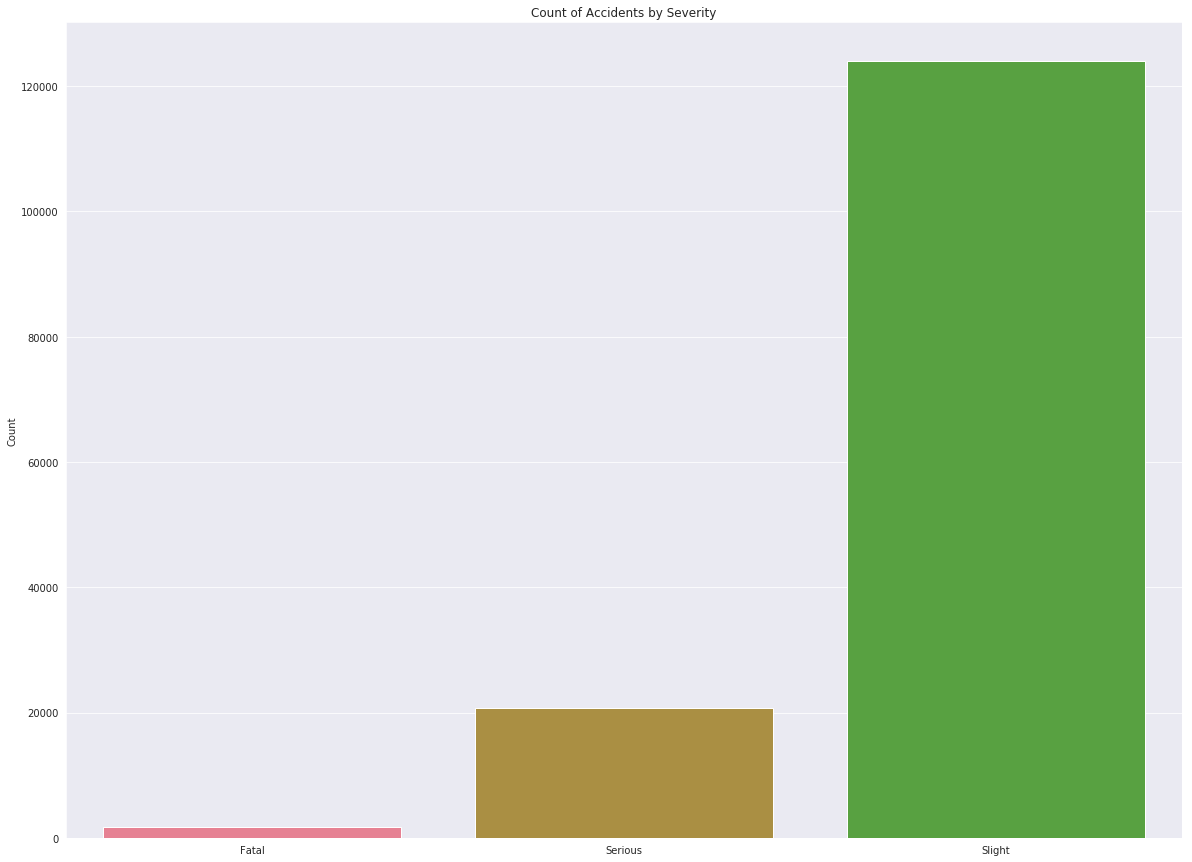

In [13]:
severeity=pd.DataFrame.from_dict(
    {'Fatal':df_acc.Accident_Severity.value_counts()[1],
             'Serious':df_acc.Accident_Severity.value_counts()[2], 
             'Slight':df_acc.Accident_Severity.value_counts()[3]},
    orient='index', columns=['Count'])

plt.figure(2, figsize=(20,15))
sns.barplot(x=severeity.index, y='Count',data=severeity)
plt.title('Count of Accidents by Severity')

severeity


,Accident_Severity,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Fatal,NO,20
1,Fatal,YES,1638
2,Serious,NO,1941
3,Serious,YES,18735
4,Slight,NO,24754
5,Slight,YES,99234


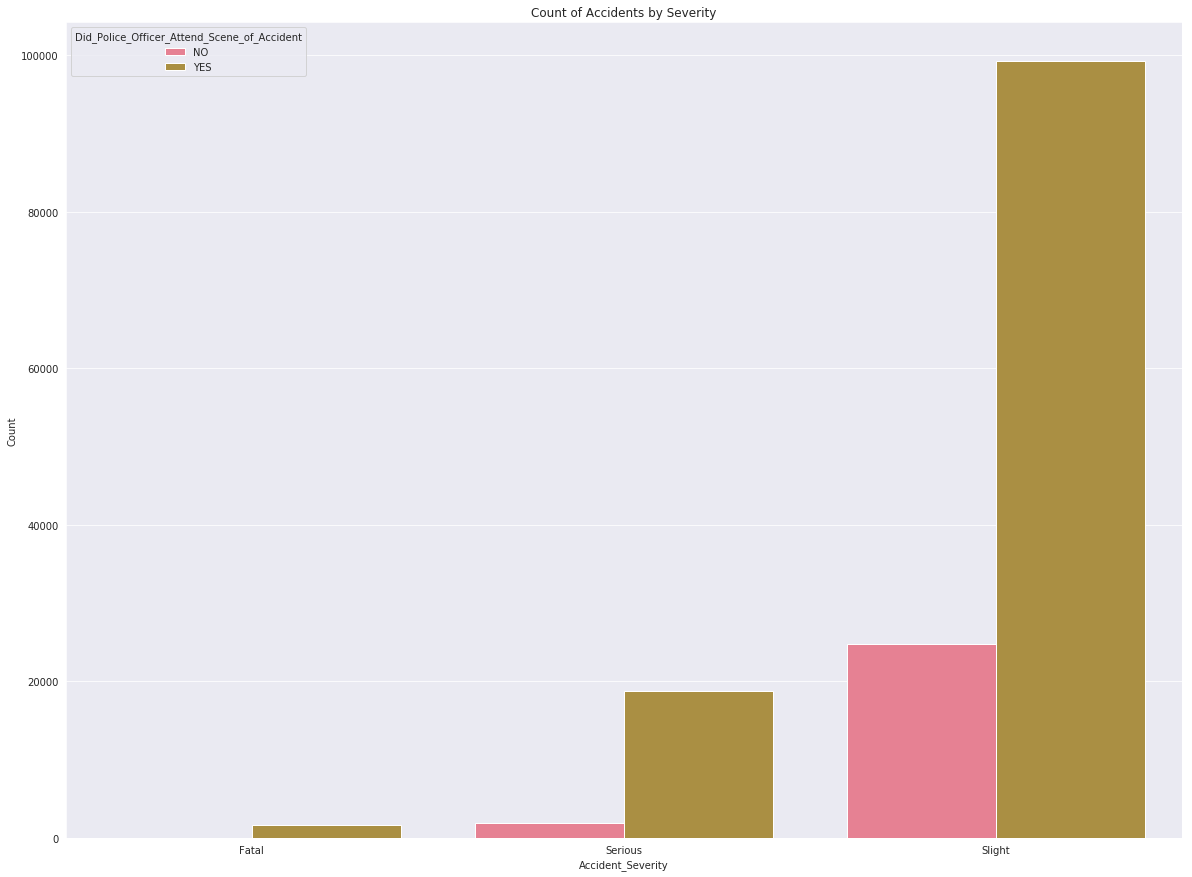

In [14]:
sever_by_attend=df_acc.replace({'Accident_Severity':{1:'Fatal',2:'Serious',3:'Slight'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Accident_Severity','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Accident_Severity','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Accident_Severity', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=sever_by_attend)
plt.ylabel("Count")
plt.title('Count of Accidents by Severity')

sever_by_attend

Text(0.5, 1.0, 'Percentage of Police Not Attending by Accident Severity')

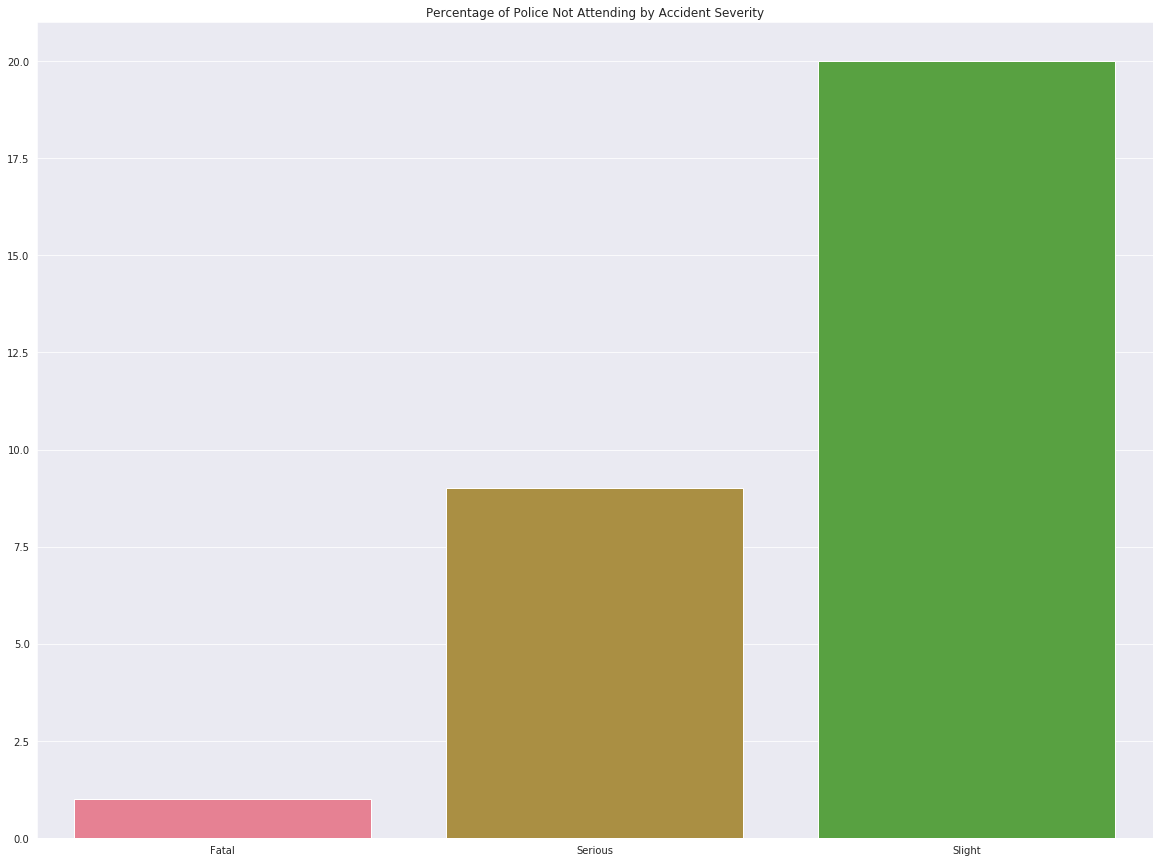

In [15]:
a=np.round((np.array(sever_by_attend.loc[
    sever_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(sever_by_attend.loc[
    sever_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(sever_by_attend.loc[
     sever_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=sever_by_attend.Accident_Severity.unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Accident Severity")

#### Number of Casualties 

/home/norayrm/.conda/envs/keras/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Histograms of Number of Casualties Attended vs Not Attended')

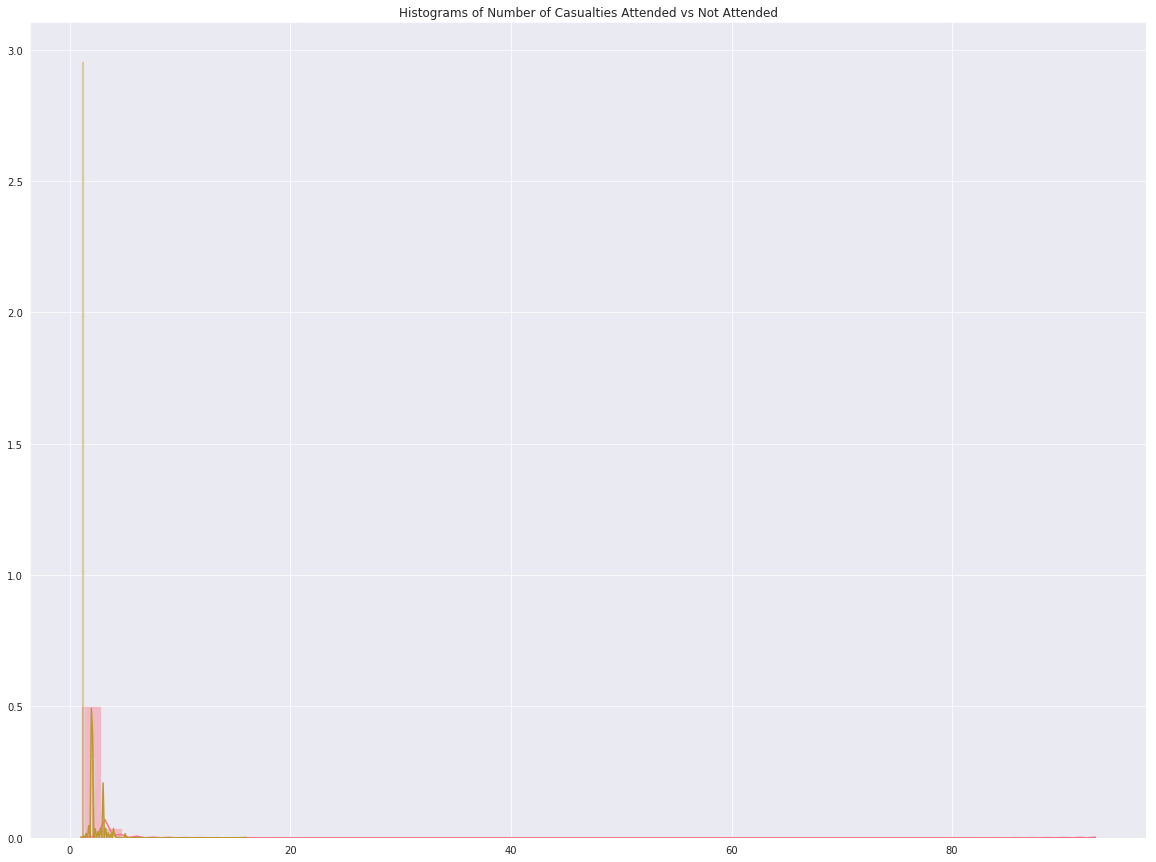

In [16]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Casualties']],bins=50,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Casualties']],bins=50,label='Not Attended')
plt.title('Histograms of Number of Casualties Attended vs Not Attended')

Text(0.5, 1.0, 'Zoomed Histograms of Number of Casualties Attended vs Not Attended')

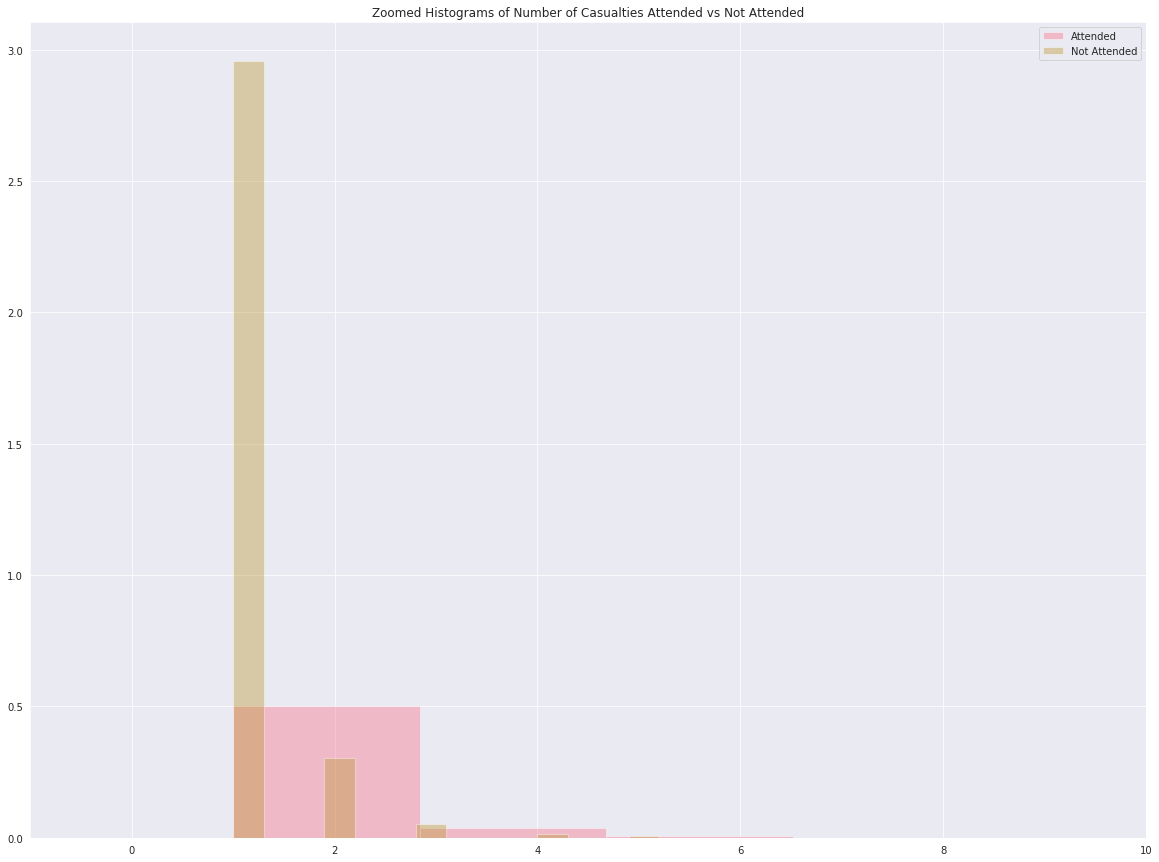

In [17]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Casualties']],norm_hist=True,bins=50,kde=False,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Casualties']],norm_hist=True,bins=50,kde=False,label='Not Attended')
plt.xlim(-1, 10)
plt.legend()
plt.title('Zoomed Histograms of Number of Casualties Attended vs Not Attended')

#### Number of Vehicles

Text(0.5, 1.0, 'Histograms of Number of Vehicles Attended vs Not Attended')

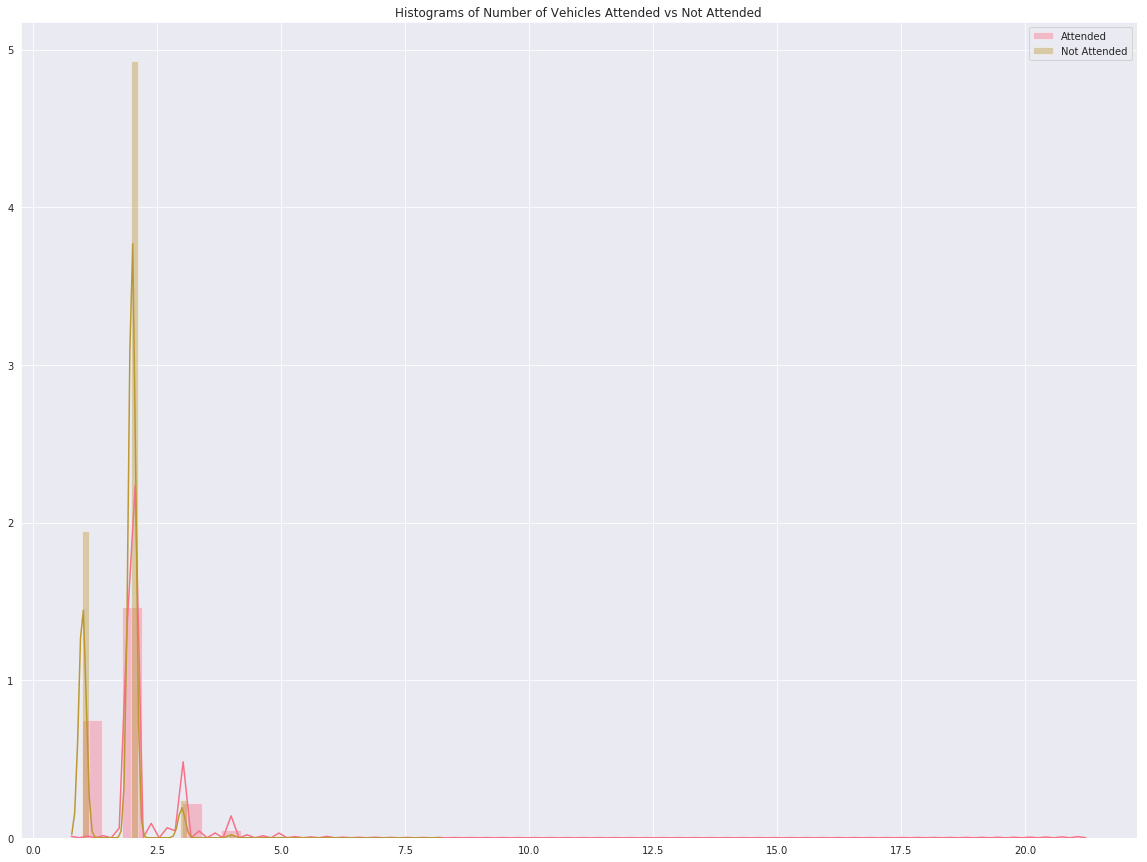

In [18]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Vehicles']],bins=50,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Vehicles']],bins=50,label='Not Attended')
plt.legend()
plt.title('Histograms of Number of Vehicles Attended vs Not Attended')

Text(0.5, 1.0, 'Zoomed Histograms of Number of Vehicles Attended vs Not Attended')

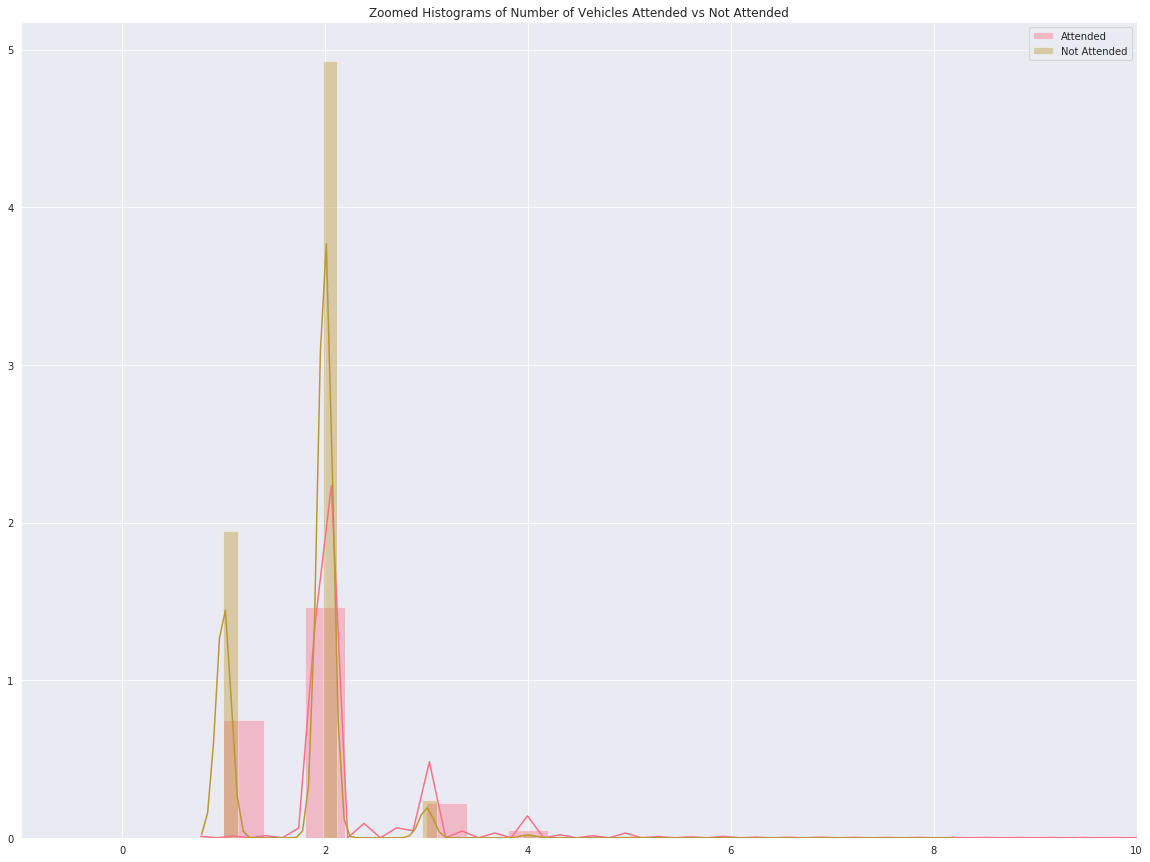

In [19]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Number_of_Vehicles']],bins=50,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Number_of_Vehicles']],bins=50,label='Not Attended')
plt.xlim(-1, 10)
plt.legend()
plt.title('Zoomed Histograms of Number of Vehicles Attended vs Not Attended')

#### 1st_Road_Class

,1st_Road_Class,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,A,NO,11024
1,A,YES,56804
2,A(M),NO,30
3,A(M),YES,354
4,B,NO,3254
5,B,YES,15319
6,C,NO,2380
7,C,YES,10589
8,Motorway,NO,389
9,Motorway,YES,4857


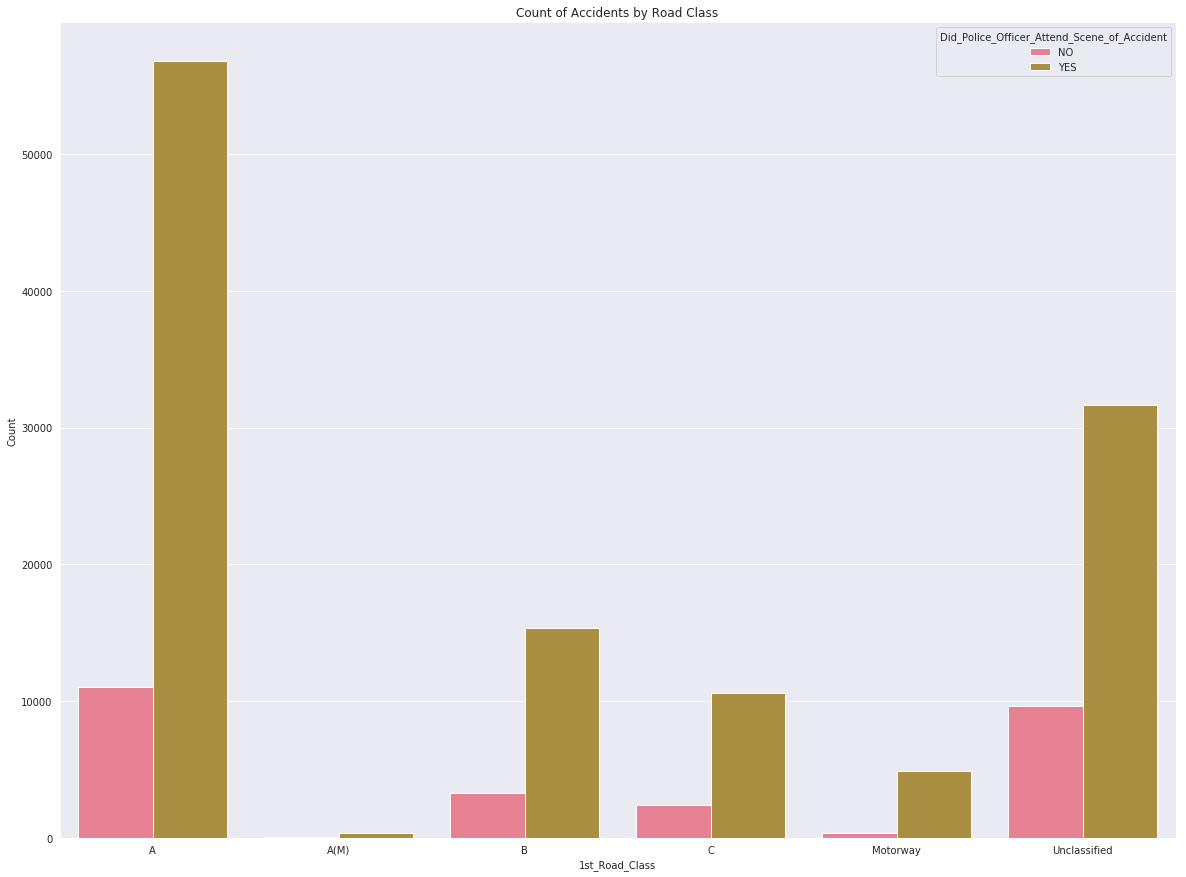

In [20]:
road_by_attend=df_acc.replace({'1st_Road_Class':
                               {1:'Motorway',2:'A(M)',3:'A',4:'B',5:'C',6:'Unclassified'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['1st_Road_Class','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['1st_Road_Class','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='1st_Road_Class', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=road_by_attend)
plt.ylabel("Count")
plt.title('Count of Accidents by Road Class')

road_by_attend

Text(0.5, 1.0, 'Percentage of Police Not Attending by Road Class')

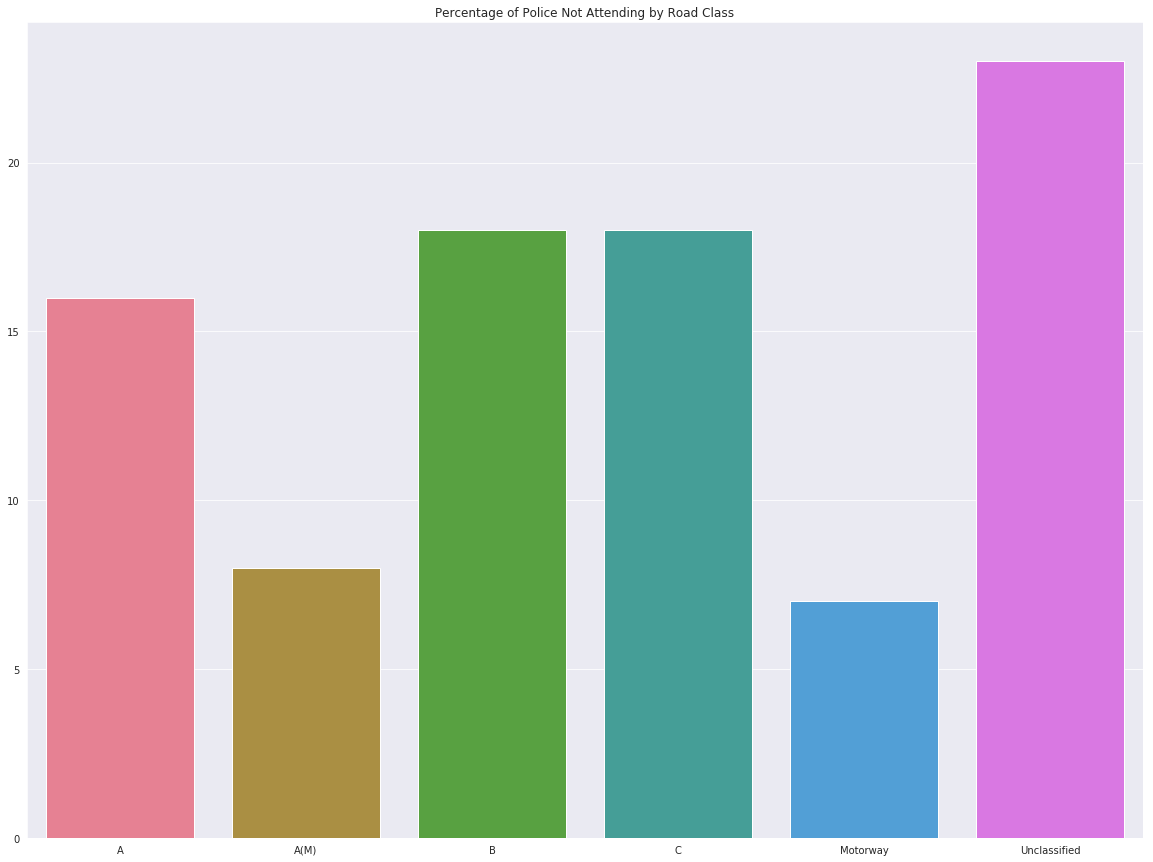

In [21]:
a=np.round((np.array(road_by_attend.loc[
    road_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(road_by_attend.loc[
    road_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(road_by_attend.loc[
     road_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=road_by_attend['1st_Road_Class'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Road Class")

#### Road_Type

,Road_Type,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Dual carriageway,NO,2664
1,Dual carriageway,YES,18159
2,One way street,NO,790
3,One way street,YES,2145
4,Roundabout,NO,2628
5,Roundabout,YES,7701
6,Single carriageway,NO,20187
7,Single carriageway,YES,90000
8,Slip road,NO,256
9,Slip road,YES,1286


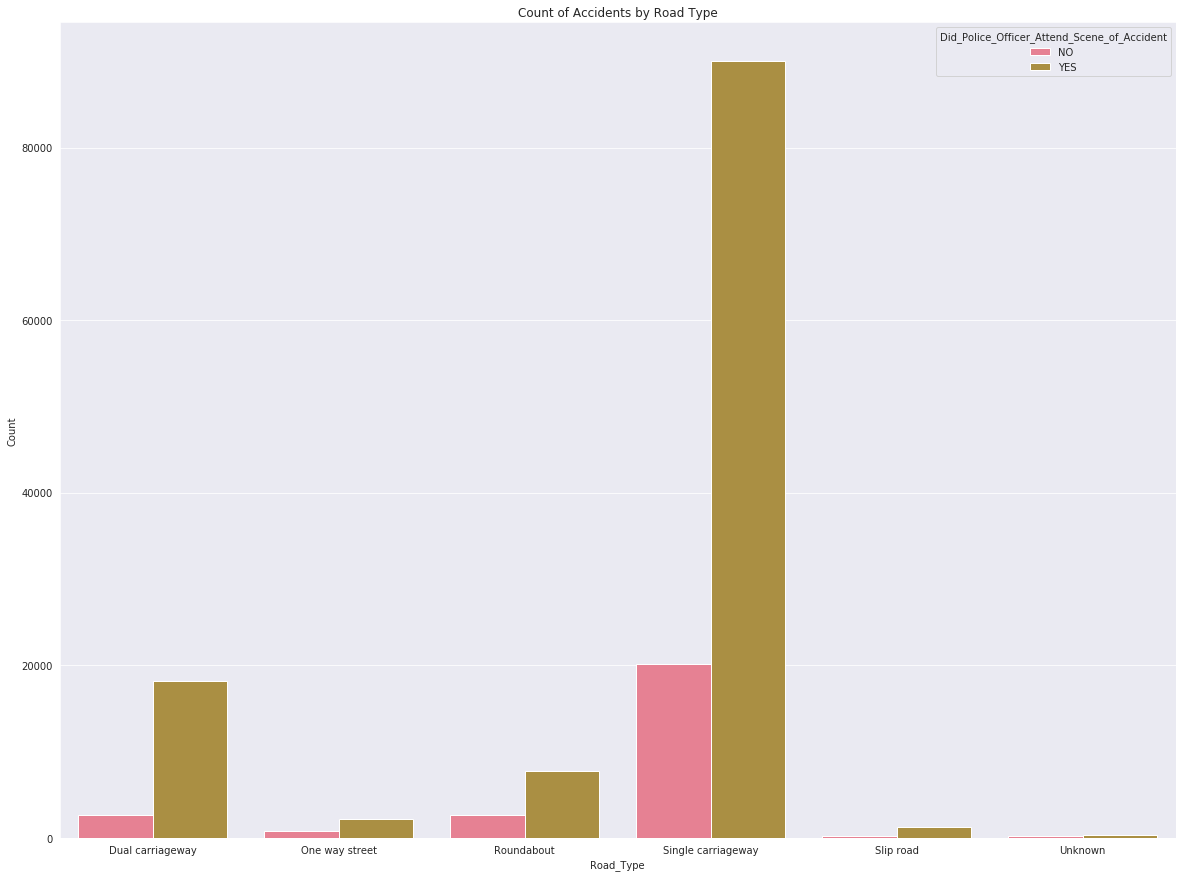

In [22]:
roadtype_by_attend=df_acc.replace({'Road_Type':
                               {1:'Roundabout',2:'One way street',3:'Dual carriageway',
                                6:'Single carriageway',7:'Slip road',9:'Unknown',
                                12:'One way street/Slip road'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Road_Type','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Road_Type','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Road_Type', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_attend)
plt.ylabel("Count")
plt.title('Count of Accidents by Road Type')
roadtype_by_attend

Text(0.5, 1.0, 'Percentage of Police Not Attending by Road Type')

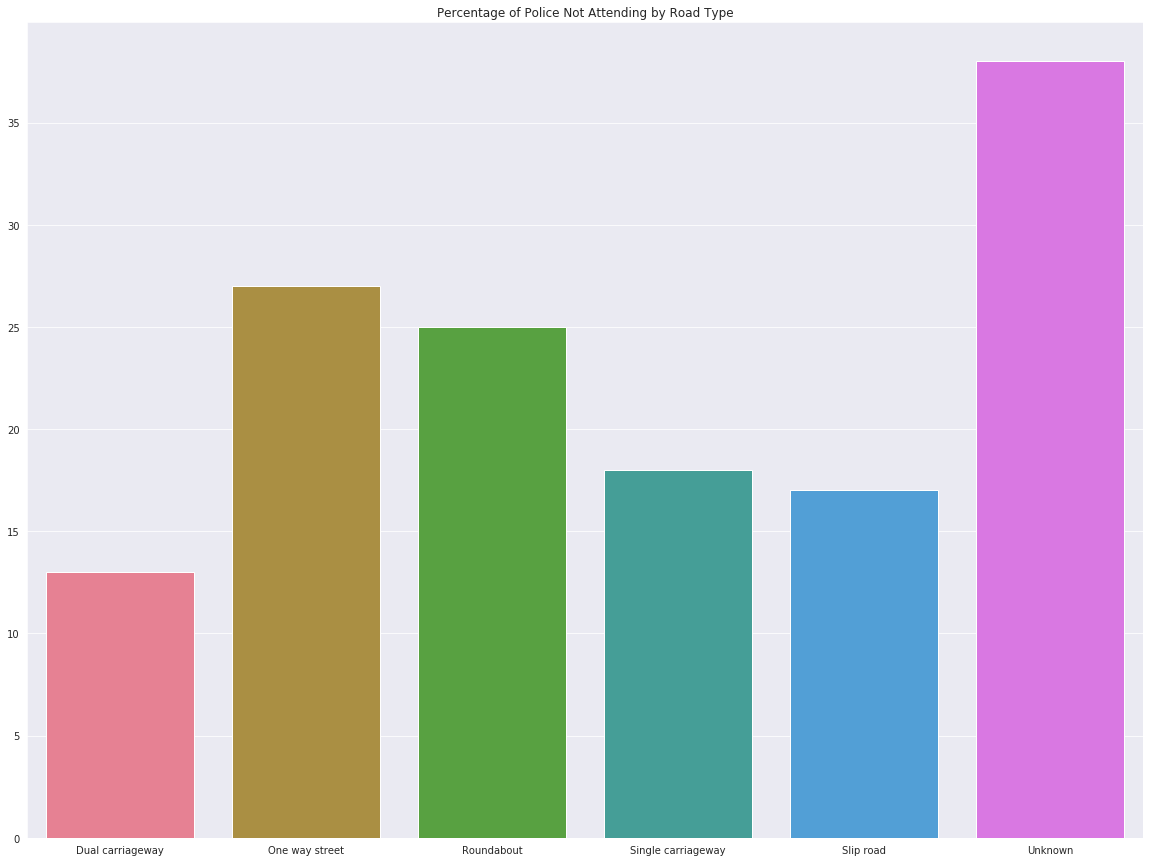

In [23]:
a=np.round((np.array(roadtype_by_attend.loc[
    roadtype_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_attend.loc[
    roadtype_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_attend.loc[
     roadtype_by_attend.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_attend['Road_Type'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Road Type")

#### Speed Limit

Text(0.5, 1.0, 'Histograms of Number of Accidents for Each Speed Limit Attended vs Not Attended')

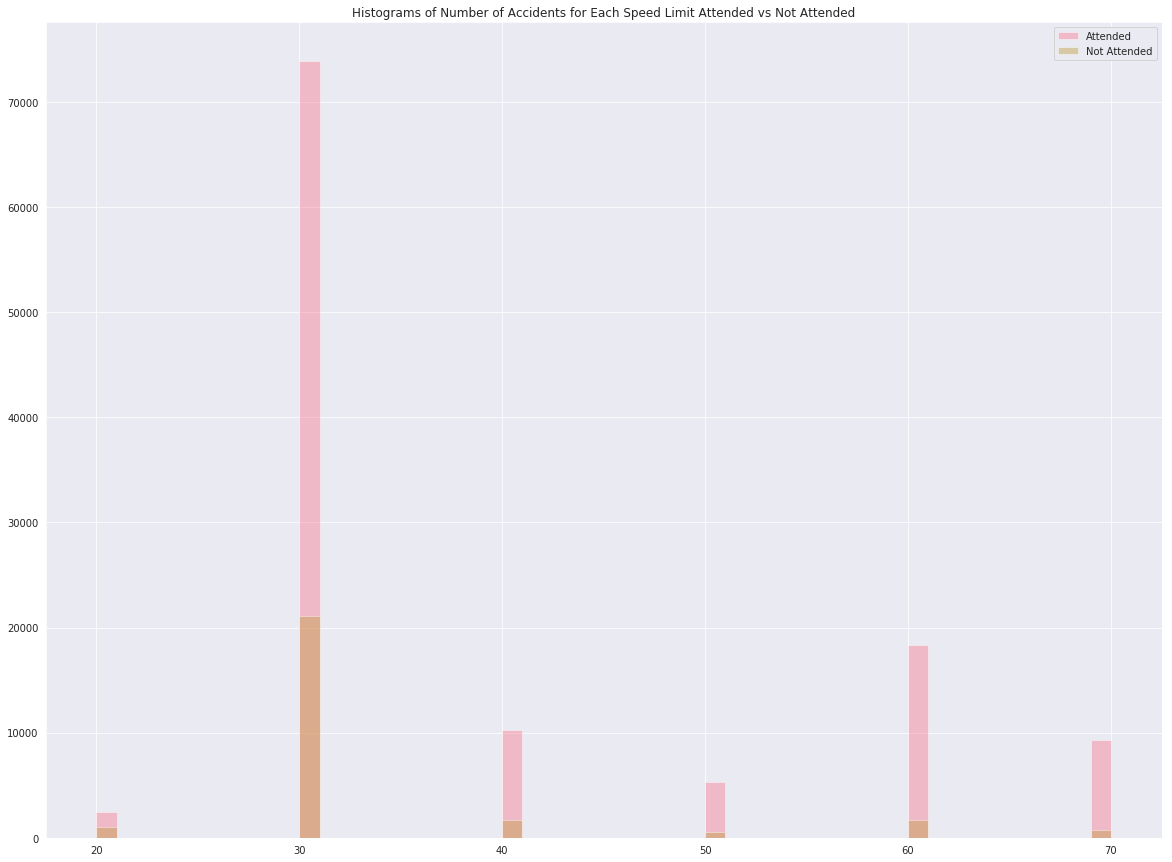

In [24]:
plt.figure(2, figsize=(20,15))
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1,
                        ['Speed_limit']],bins=50,kde=False,label="Attended")
sns.distplot(df_acc.loc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0,
                        ['Speed_limit']],bins=50,kde=False,label='Not Attended')
# plt.xlim(-1, 10)

plt.legend()
plt.title('Histograms of Number of Accidents for Each Speed Limit Attended vs Not Attended')

In [25]:
df_acc.Speed_limit.unique()

array([30, 40, 20, 50, 70, 60])

,Speed_limit,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,20,NO,980
1,20,YES,2438
2,30,NO,21110
3,30,YES,73887
4,40,NO,1727
5,40,YES,10290
6,50,NO,511
7,50,YES,5286
8,60,NO,1662
9,60,YES,18354


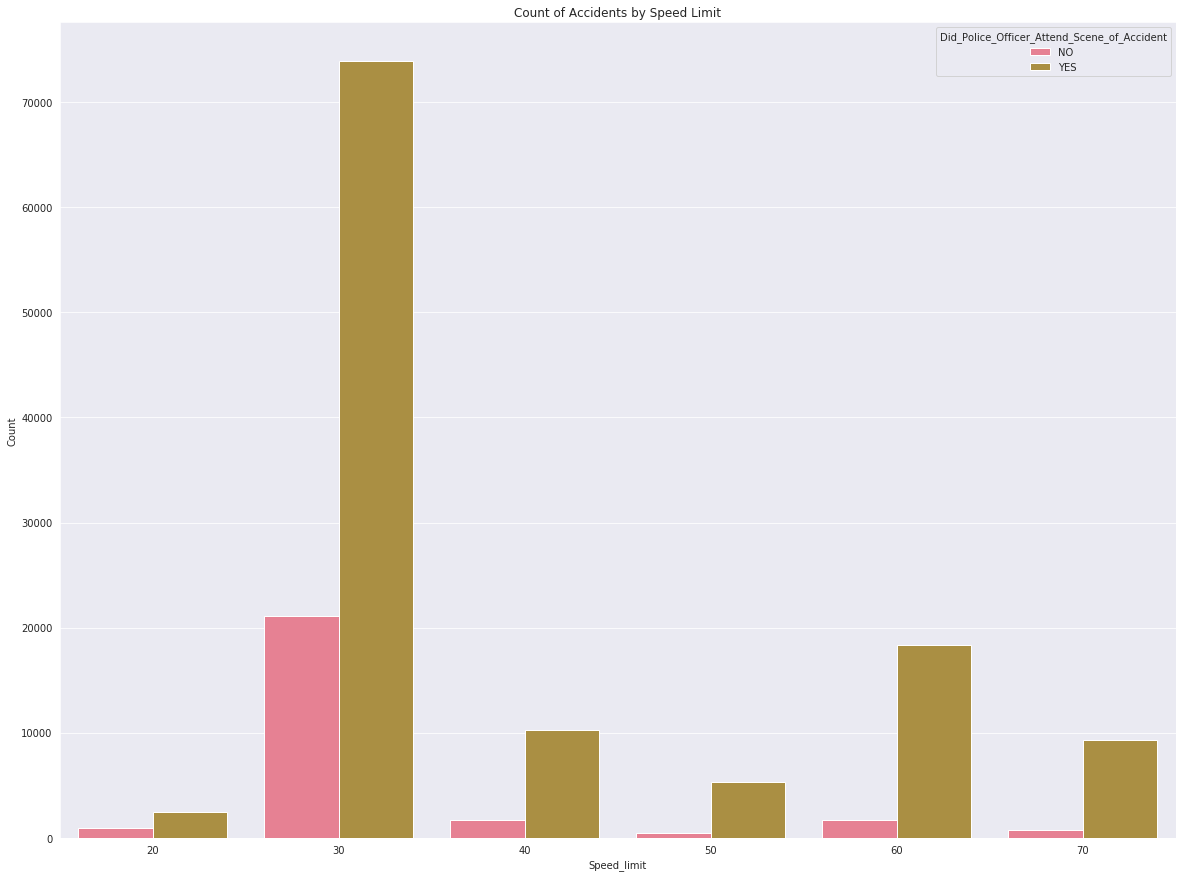

In [26]:
roadtype_by_limit=df_acc.replace({'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Speed_limit','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Speed_limit','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Speed_limit', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_limit)
plt.ylabel("Count")
plt.title('Count of Accidents by Speed Limit')
roadtype_by_limit

Text(0.5, 1.0, 'Percentage of Police Not Attending by Speed Limit')

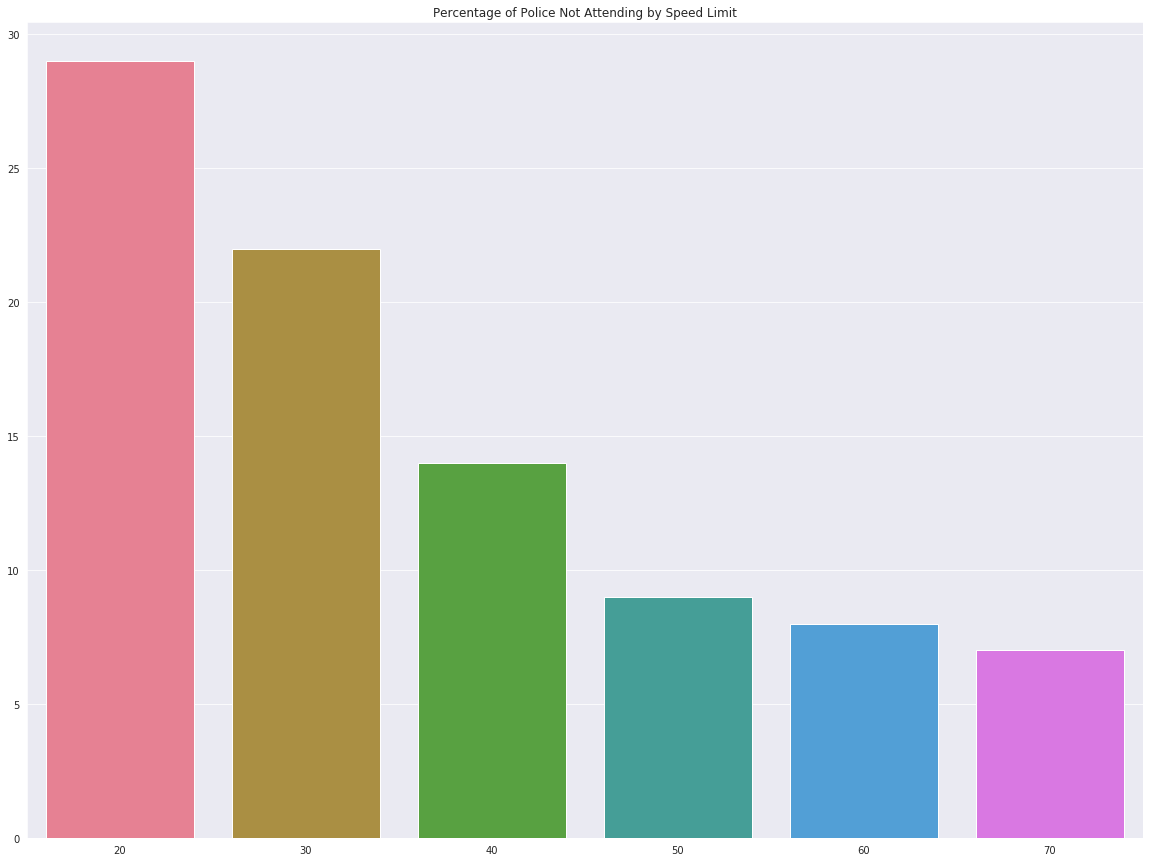

In [27]:
a=np.round((np.array(roadtype_by_limit.loc[
    roadtype_by_limit.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_limit.loc[
    roadtype_by_limit.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_limit.loc[
     roadtype_by_limit.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_limit['Speed_limit'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Speed Limit")

#### Junction Detail

,Junction_Detail,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Crossroads,NO,2320
1,Crossroads,YES,12266
2,Mini-roundabout,NO,459
3,Mini-roundabout,YES,1497
4,More than 4 arms (not roundabout),NO,187
5,More than 4 arms (not roundabout),YES,830
6,Not at junction or within 20 metres,NO,9199
7,Not at junction or within 20 metres,YES,47211
8,Other junction,NO,547
9,Other junction,YES,2578


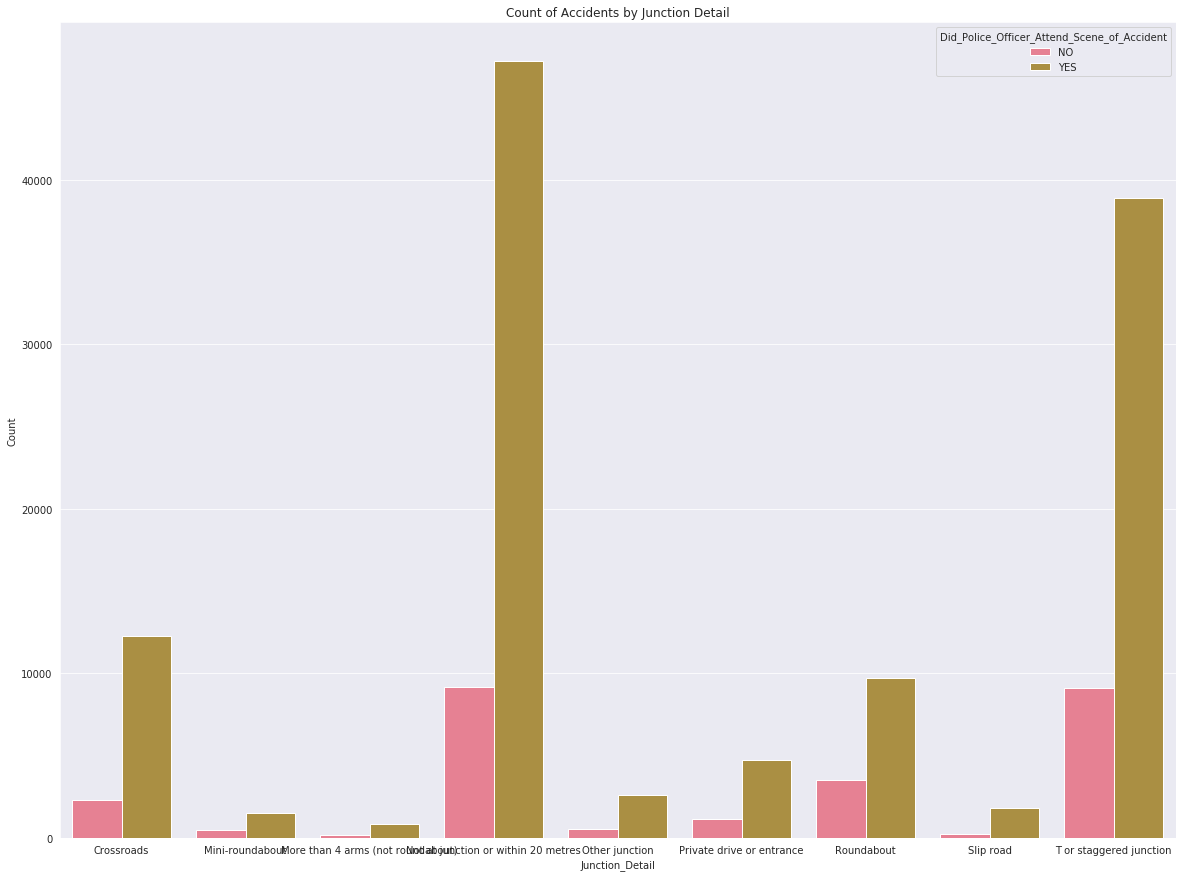

In [28]:
roadtype_by_jd=df_acc.replace({'Junction_Detail':
                               {0:'Not at junction or within 20 metres',
                                1:'Roundabout',
                                2:'Mini-roundabout',
                                3:'T or staggered junction',
                                5:'Slip road',
                                6:'Crossroads',
                                7:'More than 4 arms (not roundabout)',
                                8:'Private drive or entrance',
                                9:'Other junction'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Junction_Detail','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Junction_Detail','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Junction_Detail', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_jd)
plt.ylabel("Count")
plt.title('Count of Accidents by Junction Detail')
roadtype_by_jd

Text(0.5, 1.0, 'Percentage of Police Not Attending by Junction Detail')

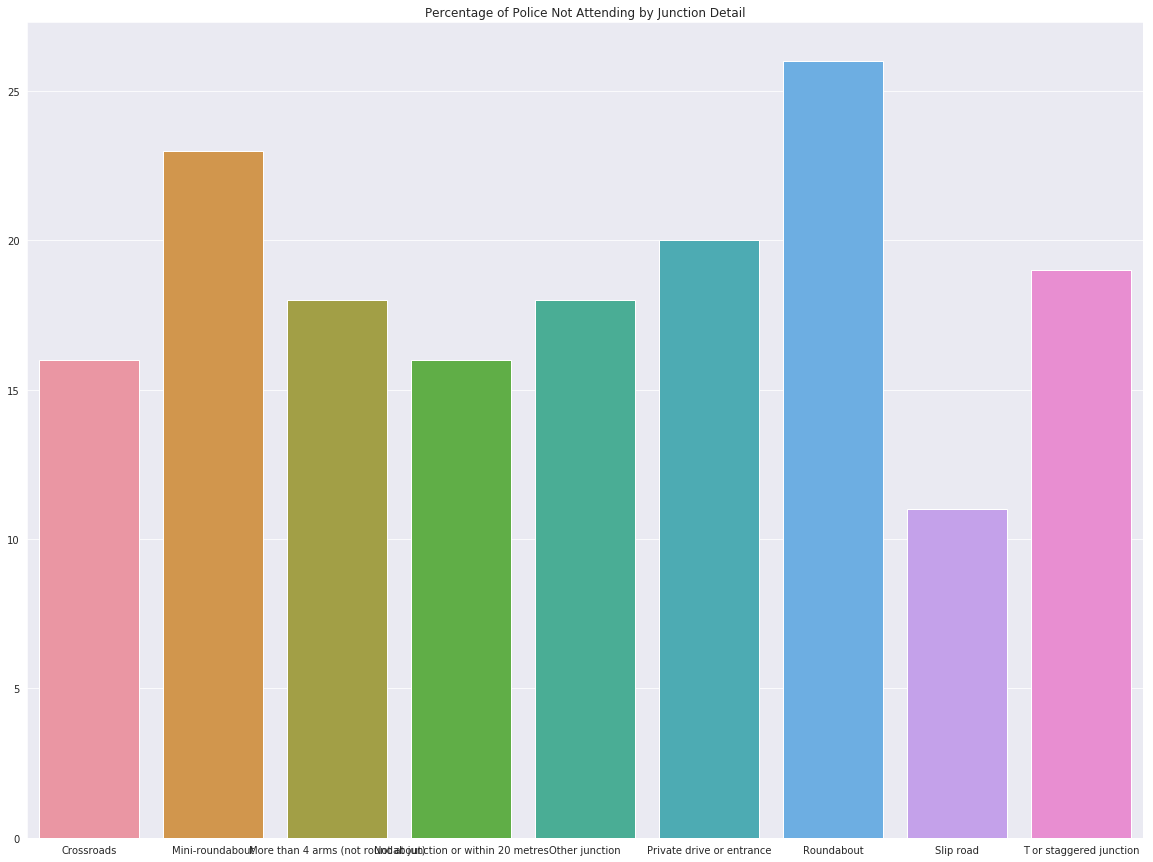

In [29]:
a=np.round((np.array(roadtype_by_jd.loc[
    roadtype_by_jd.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_jd.loc[
    roadtype_by_jd.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_jd.loc[
     roadtype_by_jd.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_jd['Junction_Detail'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Junction Detail")

#### Junction Control

,Junction_Control,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Authorised person,NO,41
1,Authorised person,YES,159
2,Auto traffic signal,NO,3130
3,Auto traffic signal,YES,12143
4,Give way or uncontrolled,NO,14210
5,Give way or uncontrolled,YES,59529
6,Stop sign,NO,130
7,Stop sign,YES,513


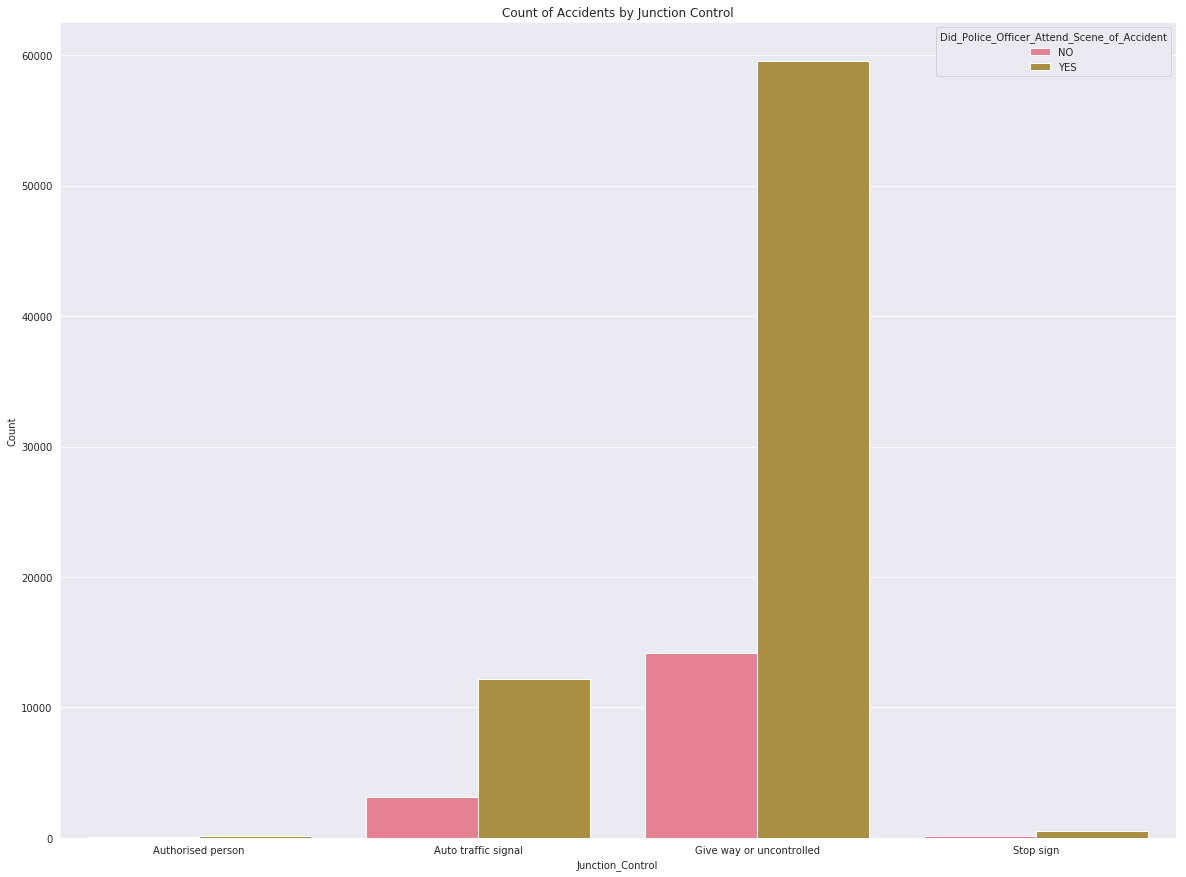

In [30]:
roadtype_by_jc=df_acc.replace({'Junction_Control':
                               {0:'Not at junction or within 20 metres',
                                1:'Authorised person',
                                2:'Auto traffic signal',
                                3:'Stop sign',
                                4:'Give way or uncontrolled',
                                -1:'Data missing or out of range'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Junction_Control','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Junction_Control','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Junction_Control', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_jc)
plt.ylabel("Count")
plt.title('Count of Accidents by Junction Control')
roadtype_by_jc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Junction Control')

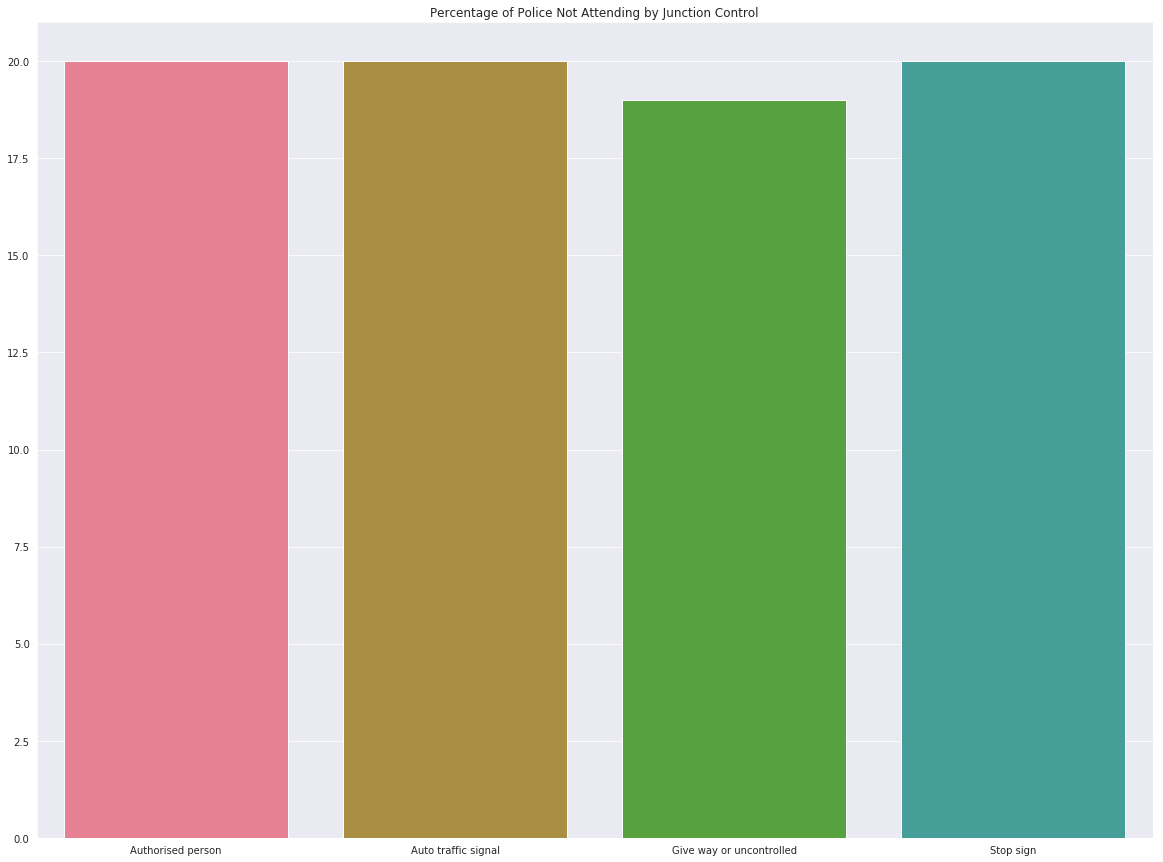

In [31]:
a=np.round((np.array(roadtype_by_jc.loc[
    roadtype_by_jc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_jc.loc[
    roadtype_by_jc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_jc.loc[
     roadtype_by_jc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_jc['Junction_Control'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Junction Control")

#### Light Conditions

,Light_Conditions,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Darkness - lighting unknown,NO,659
1,Darkness - lighting unknown,YES,1072
2,Darkness - lights lit,NO,4668
3,Darkness - lights lit,YES,23781
4,Darkness - lights unlit,NO,121
5,Darkness - lights unlit,YES,751
6,Darkness - no lighting,NO,419
7,Darkness - no lighting,YES,6780
8,Daylight,NO,20848
9,Daylight,YES,87223


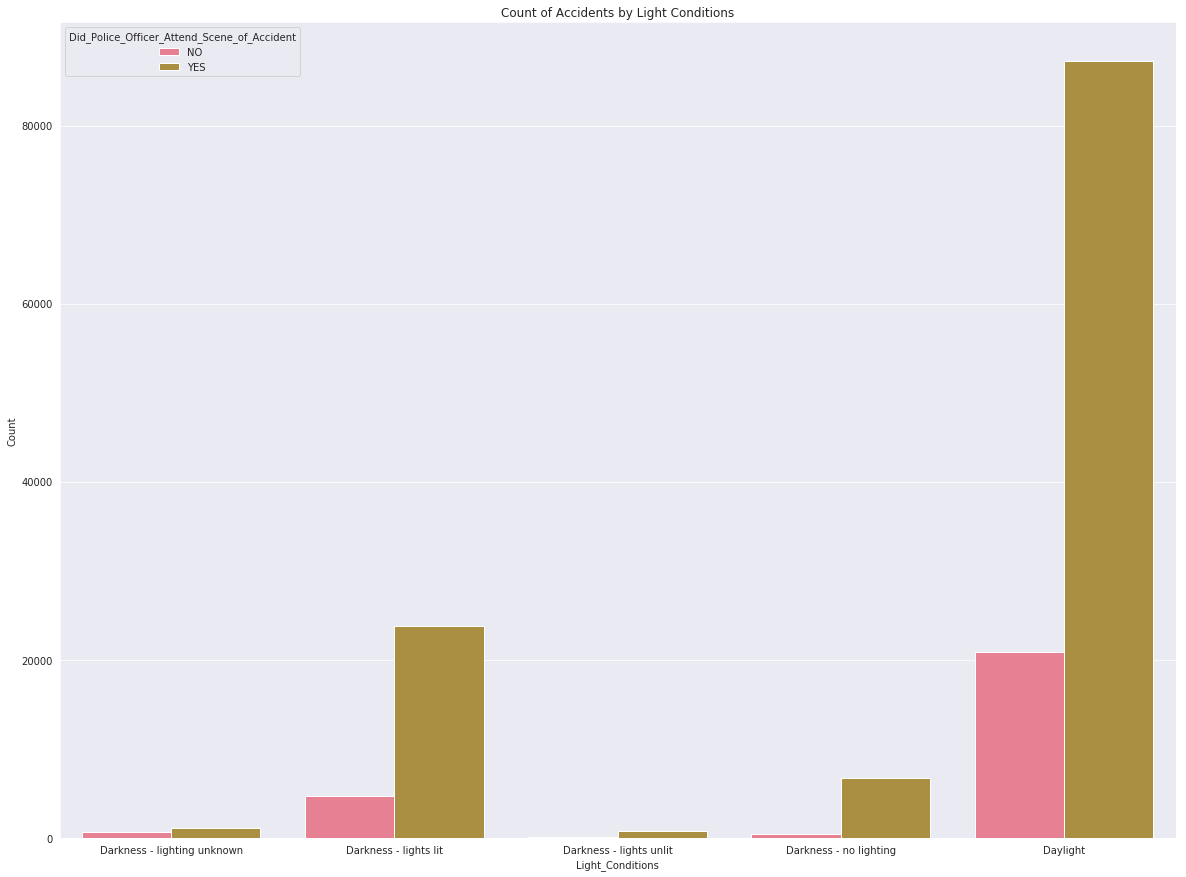

In [32]:
roadtype_by_lc=df_acc.replace({'Light_Conditions':
                               {1:'Daylight',
                                4:'Darkness - lights lit',
                                5:'Darkness - lights unlit',
                                6:'Darkness - no lighting',
                                7:'Darkness - lighting unknown'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Light_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Light_Conditions','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Light_Conditions', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_lc)
plt.ylabel("Count")
plt.title('Count of Accidents by Light Conditions')
roadtype_by_lc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Light Conditions')

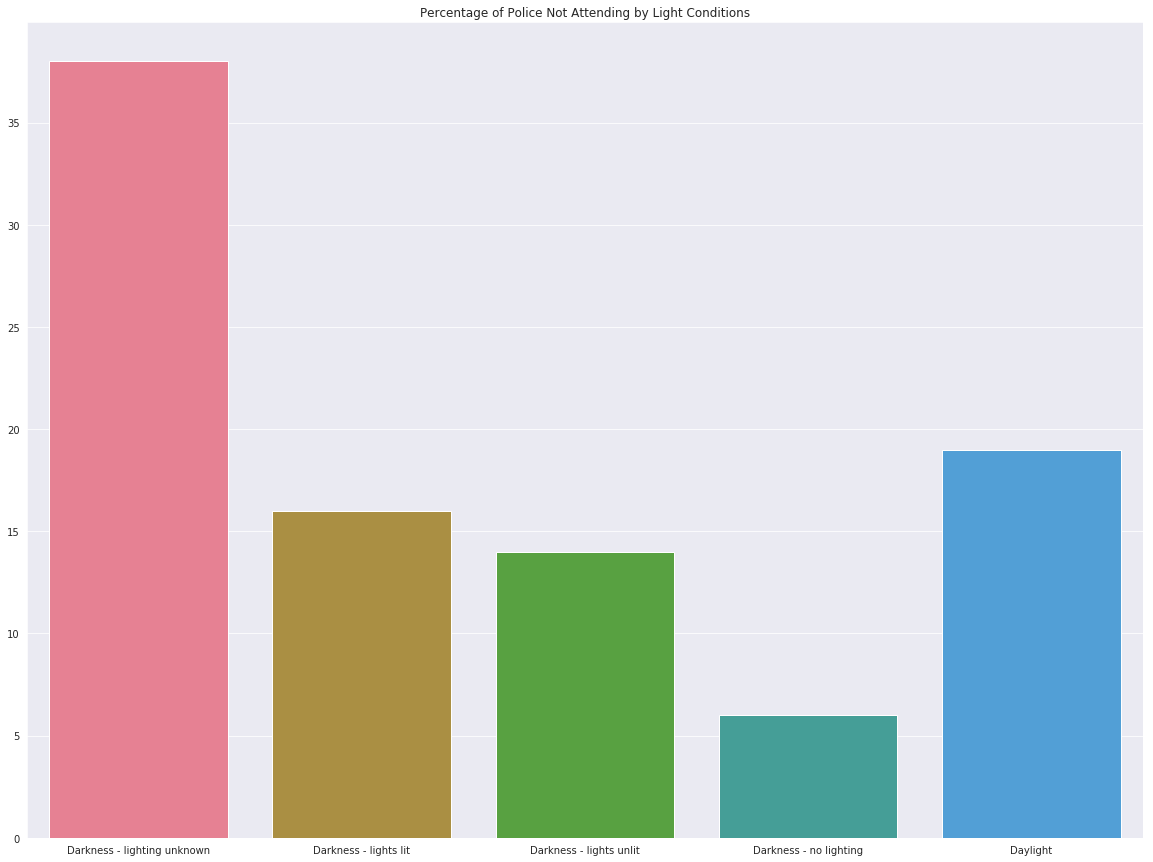

In [33]:
a=np.round((np.array(roadtype_by_lc.loc[
    roadtype_by_lc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_lc.loc[
    roadtype_by_lc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_lc.loc[
     roadtype_by_lc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_lc['Light_Conditions'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Light Conditions")

#### Weather Conditions

,Weather_Conditions,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Fine + high winds,NO,215
1,Fine + high winds,YES,1360
2,Fine no high winds,NO,21690
3,Fine no high winds,YES,97189
4,Fog or mist,NO,86
5,Fog or mist,YES,667
6,Other,NO,427
7,Other,YES,1905
8,Raining + high winds,NO,295
9,Raining + high winds,YES,2038


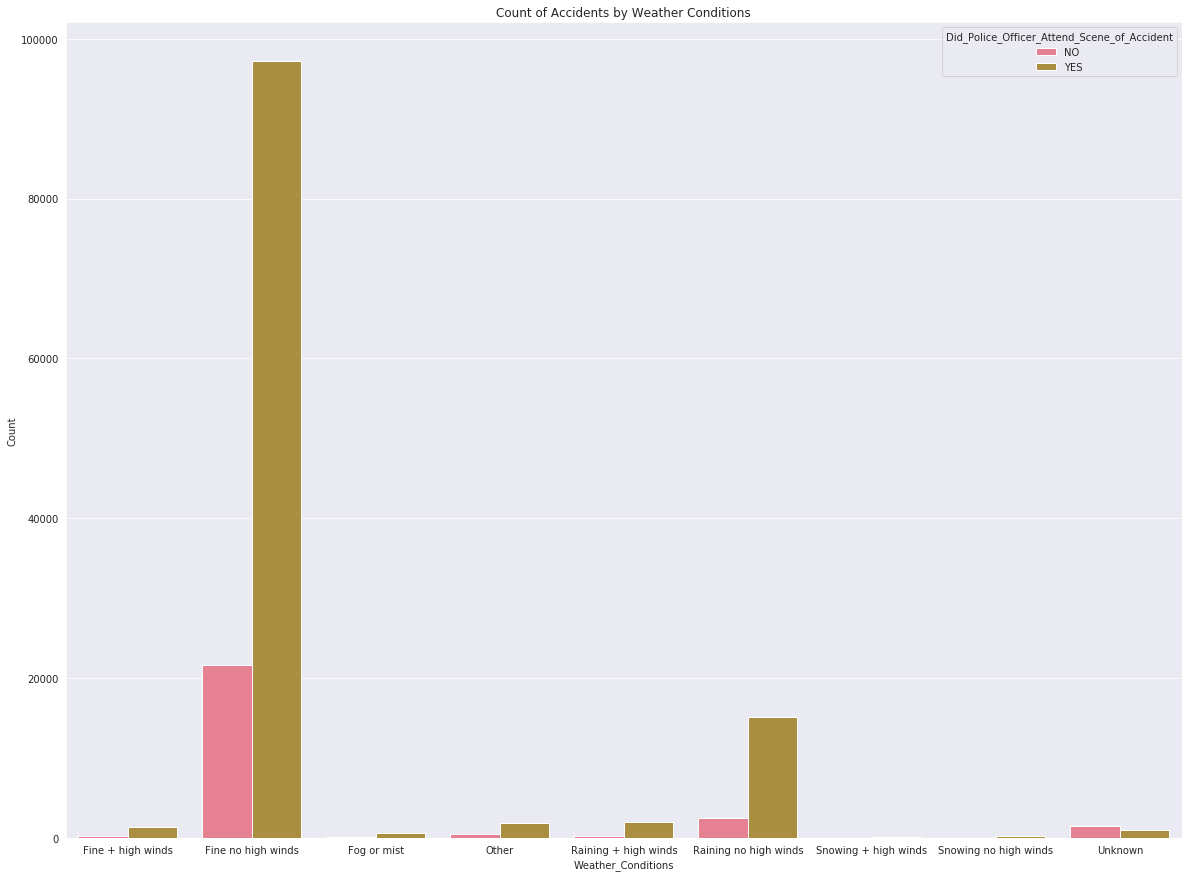

In [34]:
roadtype_by_wc=df_acc.replace({'Weather_Conditions':
                               {1:'Fine no high winds',
                                2:'Raining no high winds',
                                3:'Snowing no high winds',
                                4:'Fine + high winds',
                                5:'Raining + high winds',
                                6:'Snowing + high winds',
                                7:'Fog or mist',
                                8:'Other',
                                9:'Unknown'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Weather_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Weather_Conditions','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Weather_Conditions', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_wc)
plt.ylabel("Count")
plt.title('Count of Accidents by Weather Conditions')
roadtype_by_wc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Weather Conditions')

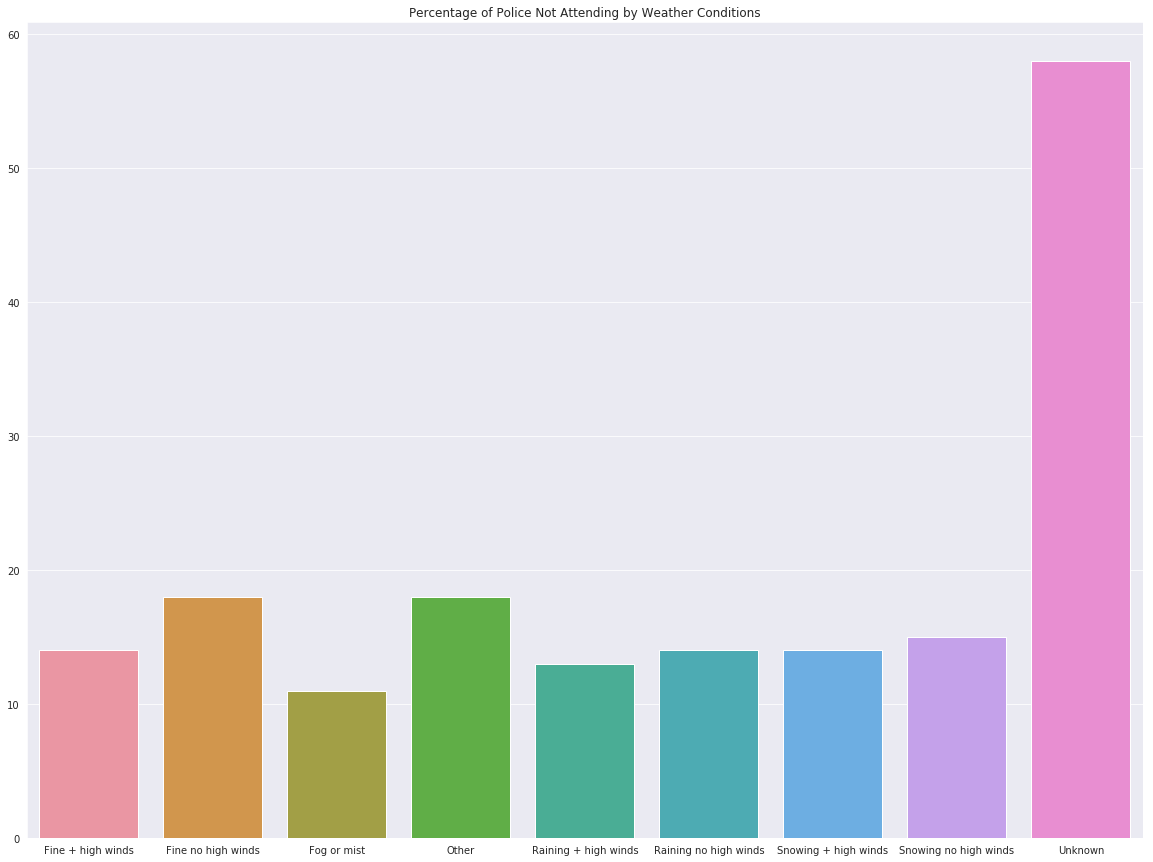

In [35]:
a=np.round((np.array(roadtype_by_wc.loc[
    roadtype_by_wc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_wc.loc[
    roadtype_by_wc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_wc.loc[
     roadtype_by_wc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_wc['Weather_Conditions'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Weather Conditions")

Possible data bleed thorugh the Unkown factor ? Could be that the condition is not recorded when the police did not attend?

#### Road Surface Conditions

,Road_Surface_Conditions,Did_Police_Officer_Attend_Scene_of_Accident,Accident_Index
0,Dry,NO,20578
1,Dry,YES,81441
2,Flood over 3cm. deep,NO,17
3,Flood over 3cm. deep,YES,245
4,Frost or ice,NO,148
5,Frost or ice,YES,1544
6,Snow,NO,36
7,Snow,YES,170
8,Wet or damp,NO,5758
9,Wet or damp,YES,36163


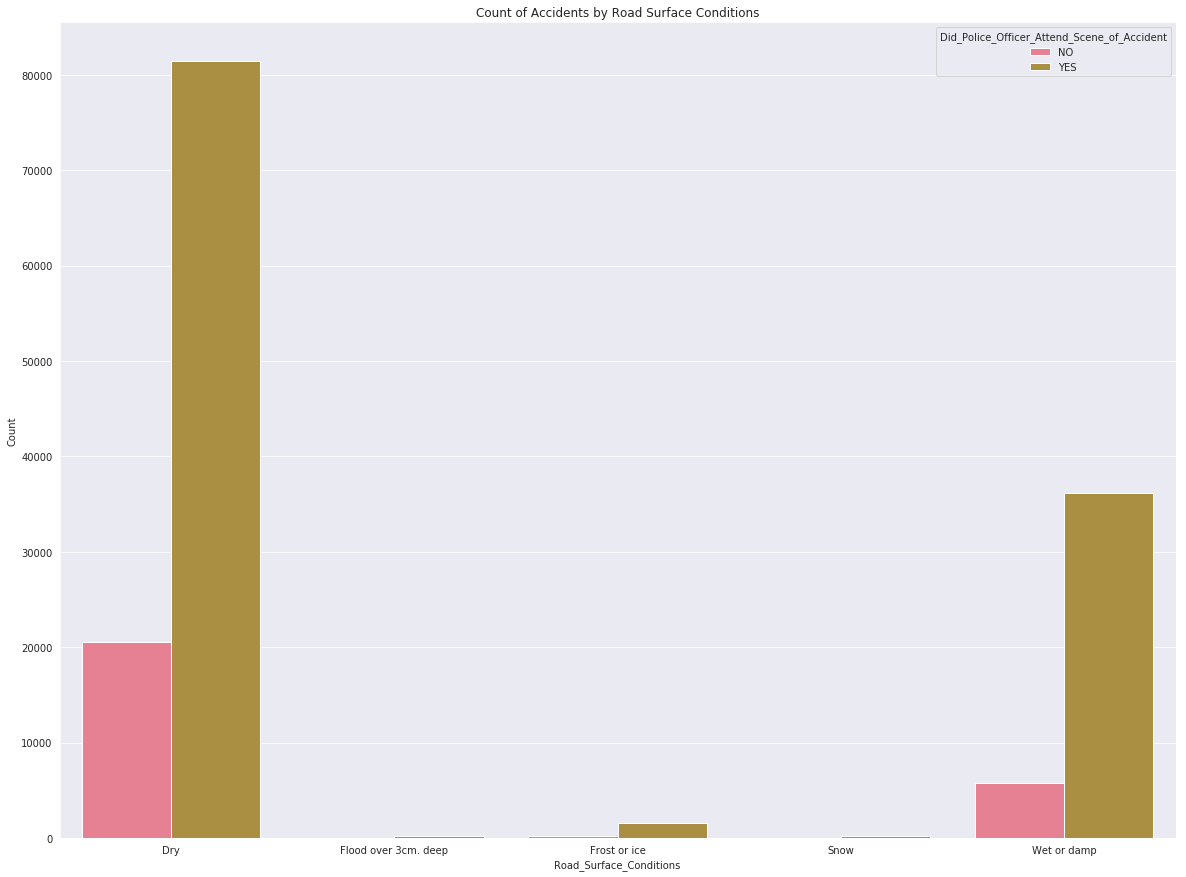

In [36]:
roadtype_by_rsc=df_acc.replace({'Road_Surface_Conditions':
                               {1:'Dry',
                                2:'Wet or damp',
                                3:'Snow',
                                4:'Frost or ice',
                                5:'Flood over 3cm. deep',
                                6:'Oil or diesel',
                                7:'Mud'},
              'Did_Police_Officer_Attend_Scene_of_Accident':{0:'NO',1:'YES'}})[
    ['Road_Surface_Conditions','Did_Police_Officer_Attend_Scene_of_Accident','Accident_Index']].groupby(
      ['Road_Surface_Conditions','Did_Police_Officer_Attend_Scene_of_Accident']).count().reset_index()

plt.figure(2, figsize=(20,15))
sns.barplot(x='Road_Surface_Conditions', y='Accident_Index', 
            hue ='Did_Police_Officer_Attend_Scene_of_Accident',
            data=roadtype_by_rsc)
plt.ylabel("Count")
plt.title('Count of Accidents by Road Surface Conditions')
roadtype_by_rsc

Text(0.5, 1.0, 'Percentage of Police Not Attending by Road Surface Conditions')

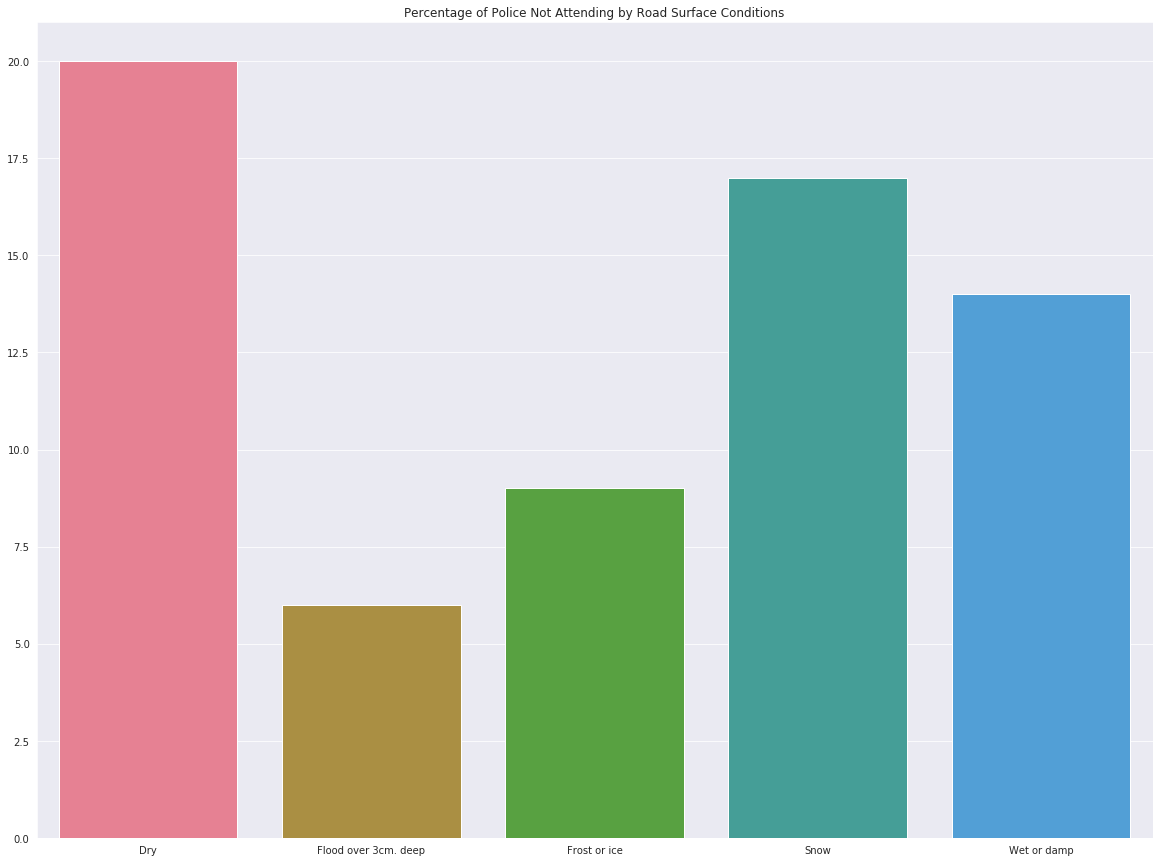

In [37]:
a=np.round((np.array(roadtype_by_rsc.loc[
    roadtype_by_rsc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']])/
  (np.array(roadtype_by_rsc.loc[
    roadtype_by_rsc.Did_Police_Officer_Attend_Scene_of_Accident=='YES',['Accident_Index']])
 +np.array(roadtype_by_rsc.loc[
     roadtype_by_rsc.Did_Police_Officer_Attend_Scene_of_Accident=='NO',['Accident_Index']]))),2)*100

plt.figure(2, figsize=(20,15))
sns.barplot(x=roadtype_by_rsc['Road_Surface_Conditions'].unique(),y=a[:,0])
plt.title("Percentage of Police Not Attending by Road Surface Conditions")

#### Time

Text(0.5, 1.0, 'Accidents per Month')

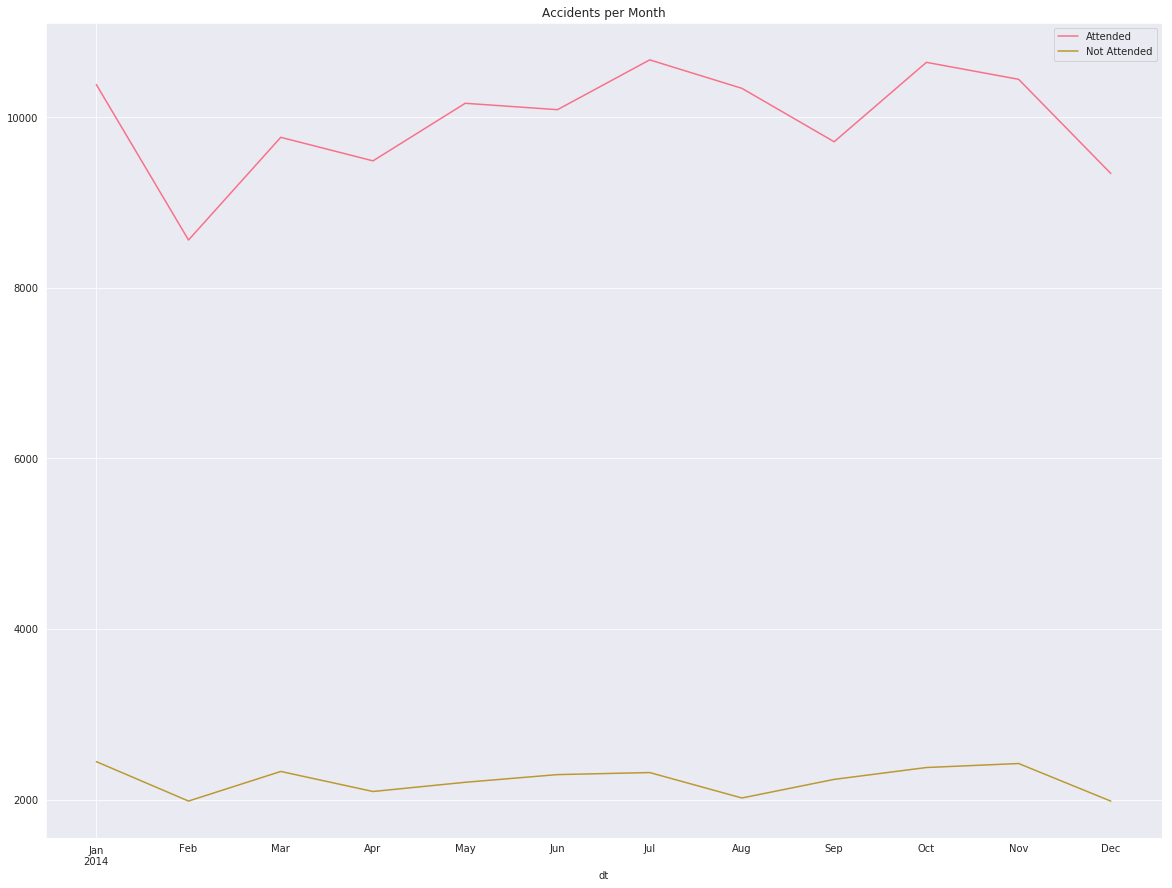

In [38]:
plt.figure(2, figsize=(20,15))
# df_acc.set_index('dt').resample('M').size().plot(label='Accidents per Month')
df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident==1
      ].set_index('dt').resample('M').size().plot(label='Attended')
df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident==0
      ].set_index('dt').resample('M').size().plot(label='Not Attended')
# sns.lineplot(x=df_acc_res_m.index,y= label='Accidents per Month'
#                             ,hue ='Did_Police_Officer_Attend_Scene_of_Accident')
plt.legend()
plt.title('Accidents per Month')
# df_acc_res_m

Text(0.5, 1.0, 'Accidents per Day')

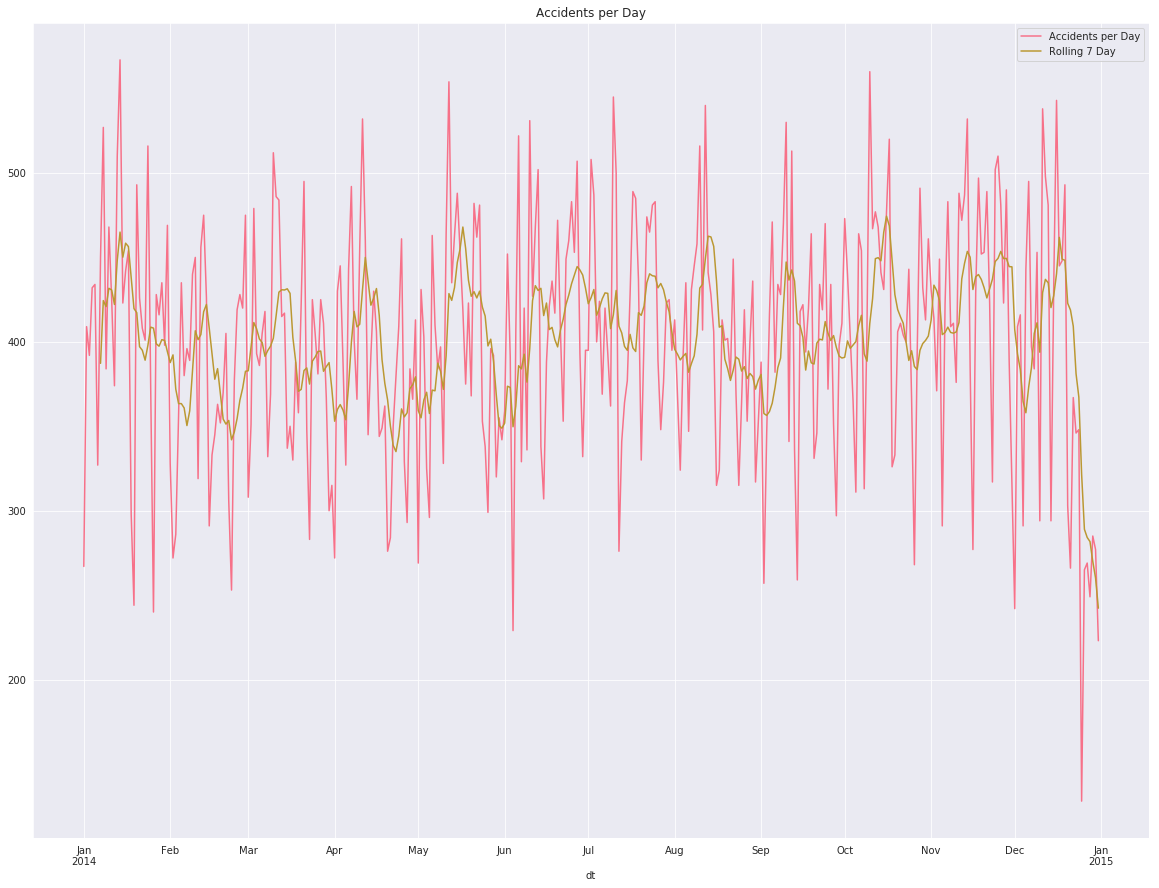

In [39]:
plt.figure(2, figsize=(20,15))
df_acc.set_index('dt').resample('D').size().plot(label='Accidents per Day')
df_acc.set_index('dt').resample('D').size().rolling(window=7).mean()\
                           .plot(label='Rolling 7 Day')
plt.legend()
plt.title('Accidents per Day')

### Checking Variable Relations

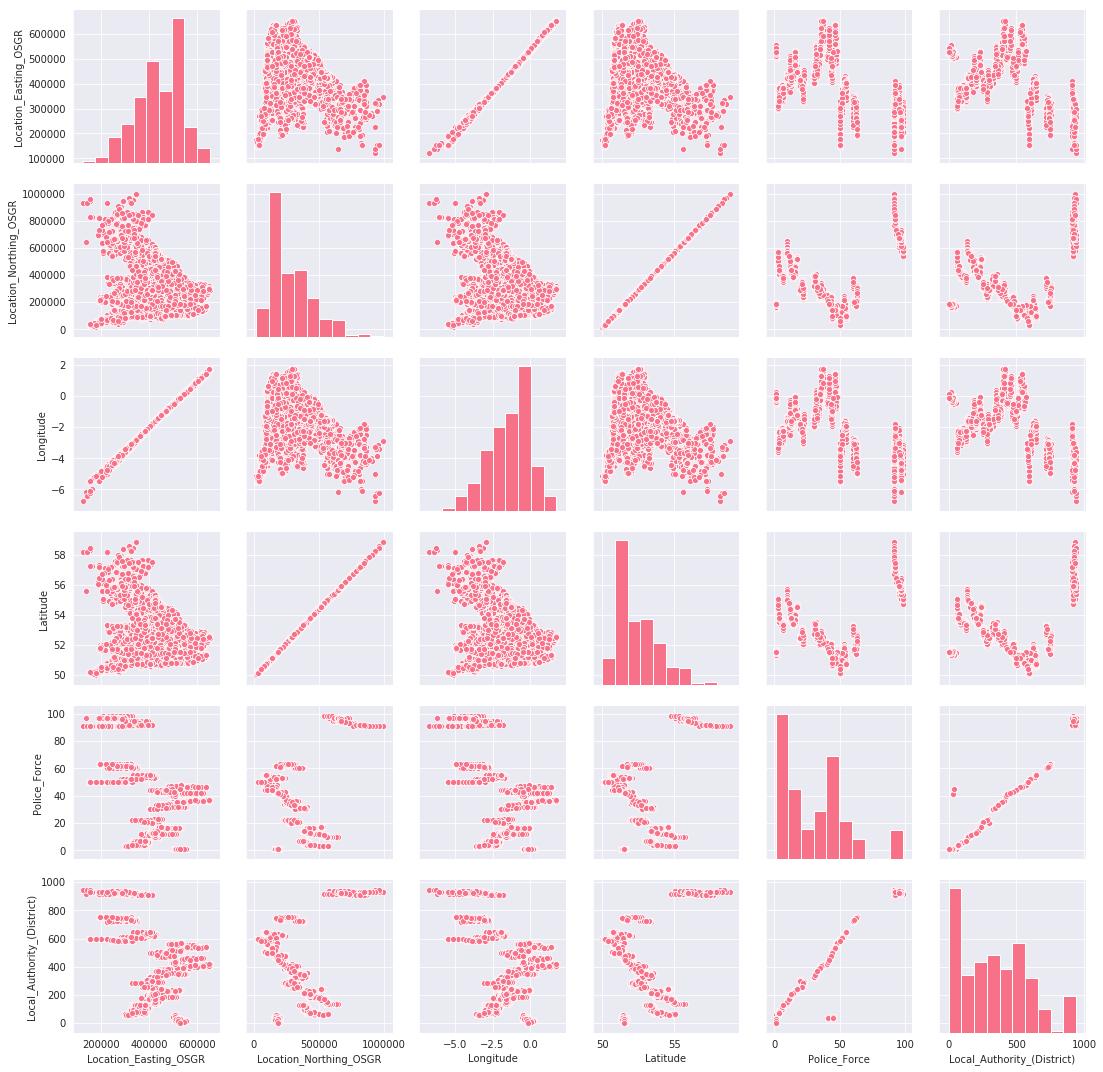

In [40]:
sns.pairplot(data=df_acc[['Location_Easting_OSGR', 
                            'Location_Northing_OSGR', 
                            'Longitude',
                            'Latitude',  
                            'Police_Force', 
                            'Local_Authority_(District)', 
                            'Local_Authority_(Highway)', 
                            'LSOA_of_Accident_Location',
                            ]].sample(frac = 0.1))

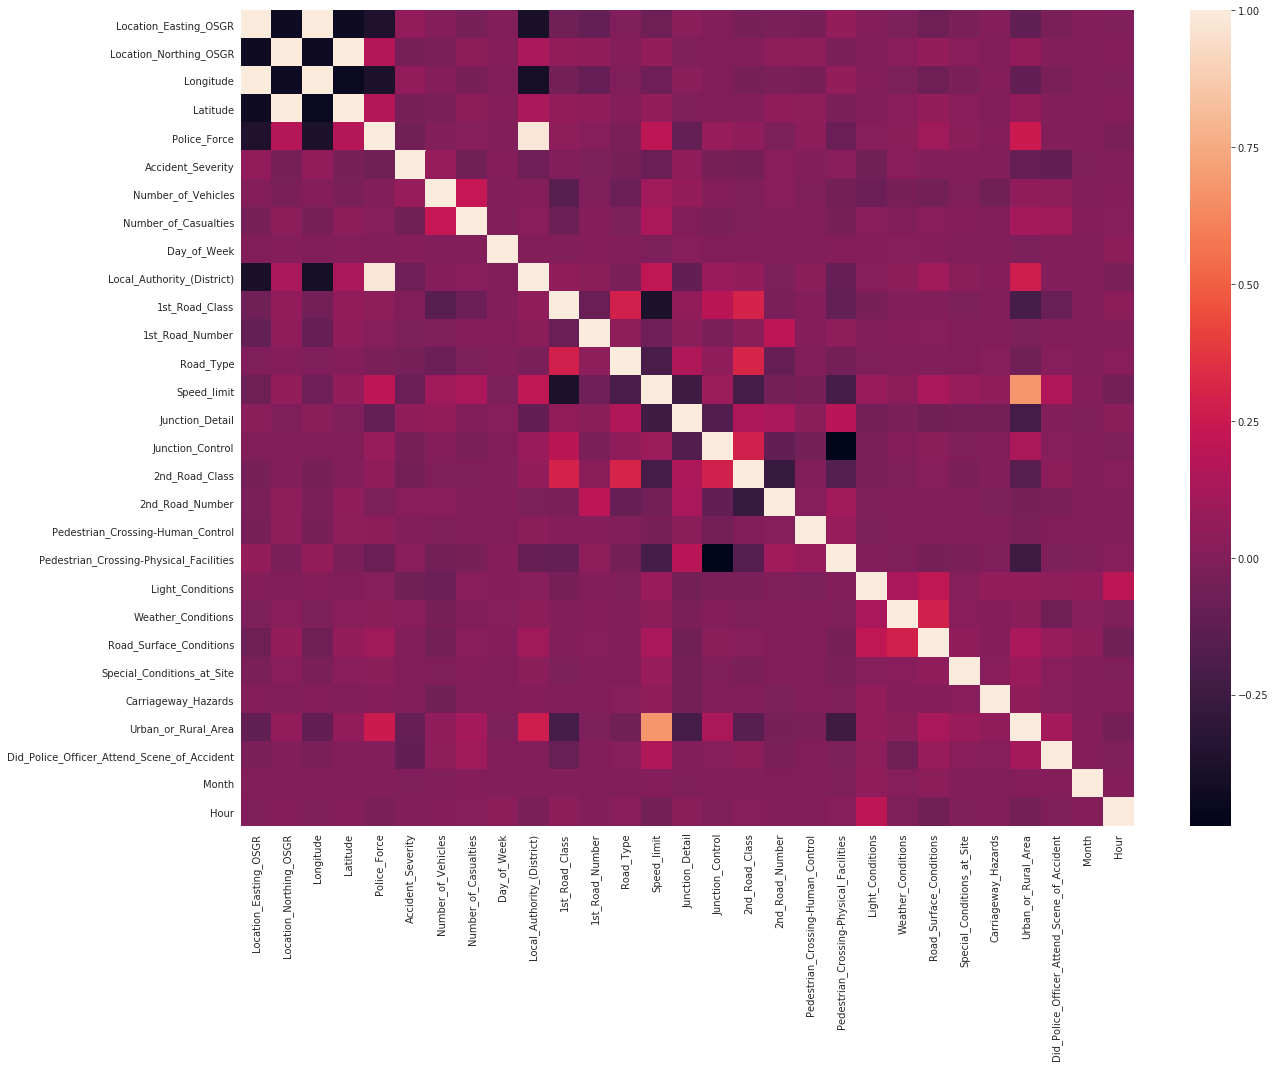

In [41]:
plt.figure(2, figsize=(20,15))
sns.heatmap(df_acc.corr())

### Feature Engineering

#### Time 

In [42]:
df_acc['Time_int'] = pd.to_datetime(df_acc.Time).astype(int)/10**9

In [43]:
df_acc['Date_int'] = pd.to_datetime(df_acc.Date).astype(int)/10**9

#### Holidays and Shifted Holidays 

In [44]:
uk_holidays = holidays.UK()
uk_holidays['2014-01-01': '2014-12-31']

[datetime.date(2014, 1, 1),
 datetime.date(2014, 1, 2),
 datetime.date(2014, 3, 17),
 datetime.date(2014, 4, 18),
 datetime.date(2014, 4, 21),
 datetime.date(2014, 5, 5),
 datetime.date(2014, 5, 26),
 datetime.date(2014, 7, 12),
 datetime.date(2014, 8, 4),
 datetime.date(2014, 8, 25),
 datetime.date(2014, 11, 30),
 datetime.date(2014, 12, 25),
 datetime.date(2014, 12, 26)]

In [45]:
# creating holidays
df_acc['Holiday'] = [ i in uk_holidays for i in df_acc.Date]
#shifting the holidays
df_acc['Holiday-1'] = [ i in uk_holidays for i in df_acc.dt -pd.Timedelta(days=1)]
df_acc['Holiday-2'] = [ i in uk_holidays for i in df_acc.dt -pd.Timedelta(days=2)]
df_acc['Holiday+1'] = [ i in uk_holidays for i in df_acc.dt +pd.Timedelta(days=1)]
df_acc['Holiday+2'] = [ i in uk_holidays for i in df_acc.dt +pd.Timedelta(days=2)]

In [46]:
#check
df_acc.loc[df_acc.Date=='26/12/2014',['Date','Holiday','Holiday-1','Holiday-2',
                                      'Holiday+1','Holiday+2']].head()

,Date,Holiday,Holiday-1,Holiday-2,Holiday+1,Holiday+2
702,26/12/2014,True,True,False,False,False
1067,26/12/2014,True,True,False,False,False
2651,26/12/2014,True,True,False,False,False
2653,26/12/2014,True,True,False,False,False
2655,26/12/2014,True,True,False,False,False


#### Rounding the time to nearest half 15min

In [47]:
df_acc['Time_rounded'] = df_acc.dt.dt.round('15min').dt.strftime('%H:%M')
df_acc[['dt','Time','Time_rounded','Time_int']].head()

,dt,Time,Time_rounded,Time_int
0,2014-09-01 13:21:00,13:21,13:15,1.578922e+09
1,2014-01-20 23:00:00,23:00,23:00,1.578956e+09
2,2014-01-21 10:40:00,10:40,10:45,1.578912e+09
3,2014-01-15 17:45:00,17:45,17:45,1.578938e+09
4,2014-09-01 08:50:00,08:50,08:45,1.578905e+09


Text(0.5, 1.0, 'Heatmap of the count of accidents by rounded hour')

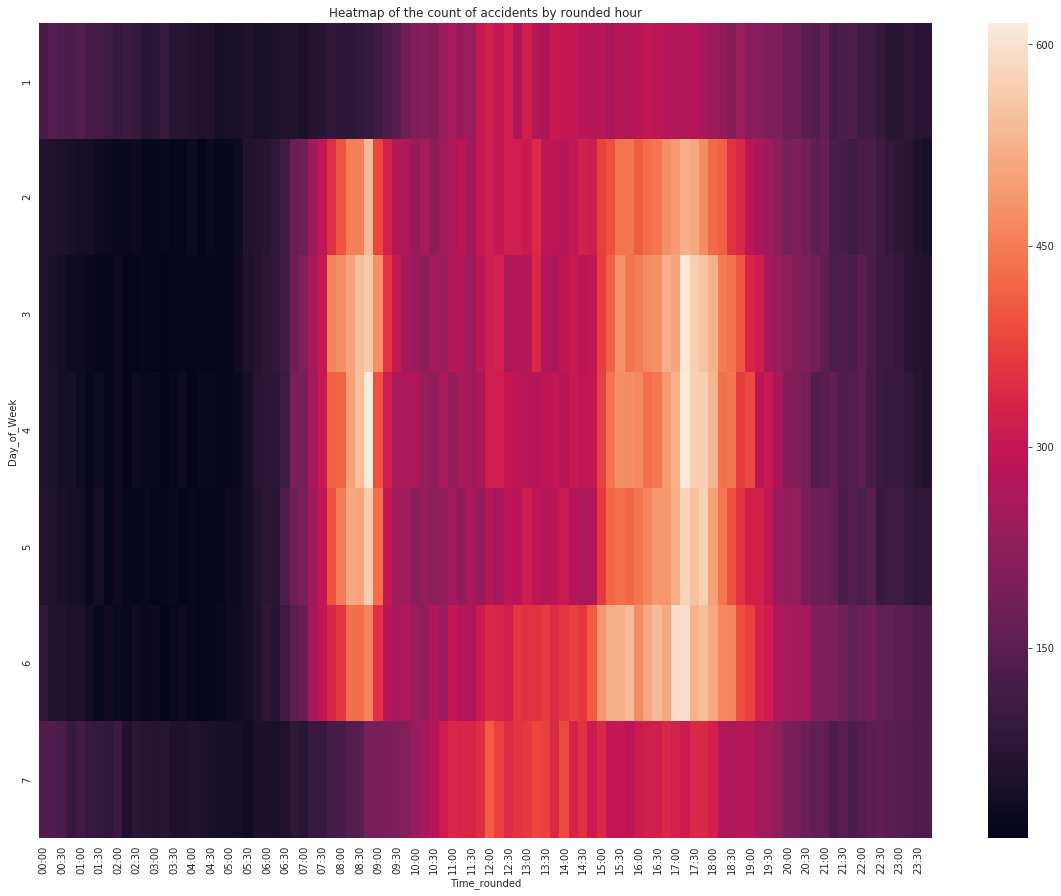

In [90]:
df_wt=df_acc.groupby(['Day_of_Week','Time_rounded']).size().unstack()
plt.figure(2, figsize=(20,15))
sns.heatmap(data=df_wt)
plt.title('Heatmap of the count of accidents by rounded hour')

#### Building the rush hour

In [49]:
def rush_hour(hour):
    if hour >= 6 and hour < 9:
        return "6-9"
    elif hour >= 9 and hour < 15:
        return "9-15"
    elif hour >= 15 and hour < 19:
        return "15-19"
    elif hour >= 19 and hour < 22:
        return "19-22"
    else:
        return "22-6"
df_acc['Rush Hour'] = df_acc['Hour'].apply(rush_hour)
df_acc[['Time', 'Hour', 'Rush Hour']].head(8)

,Time,Hour,Rush Hour
0,13:21,13,9-15
1,23:00,23,22-6
2,10:40,10,9-15
3,17:45,17,15-19
4,08:50,8,6-9
5,14:11,14,9-15
6,18:25,18,15-19
7,17:50,17,15-19


Checking the potential data leak through the Time variable

Text(0.5, 1.0, 'Heatmap of the count of accidents by unrounded time')

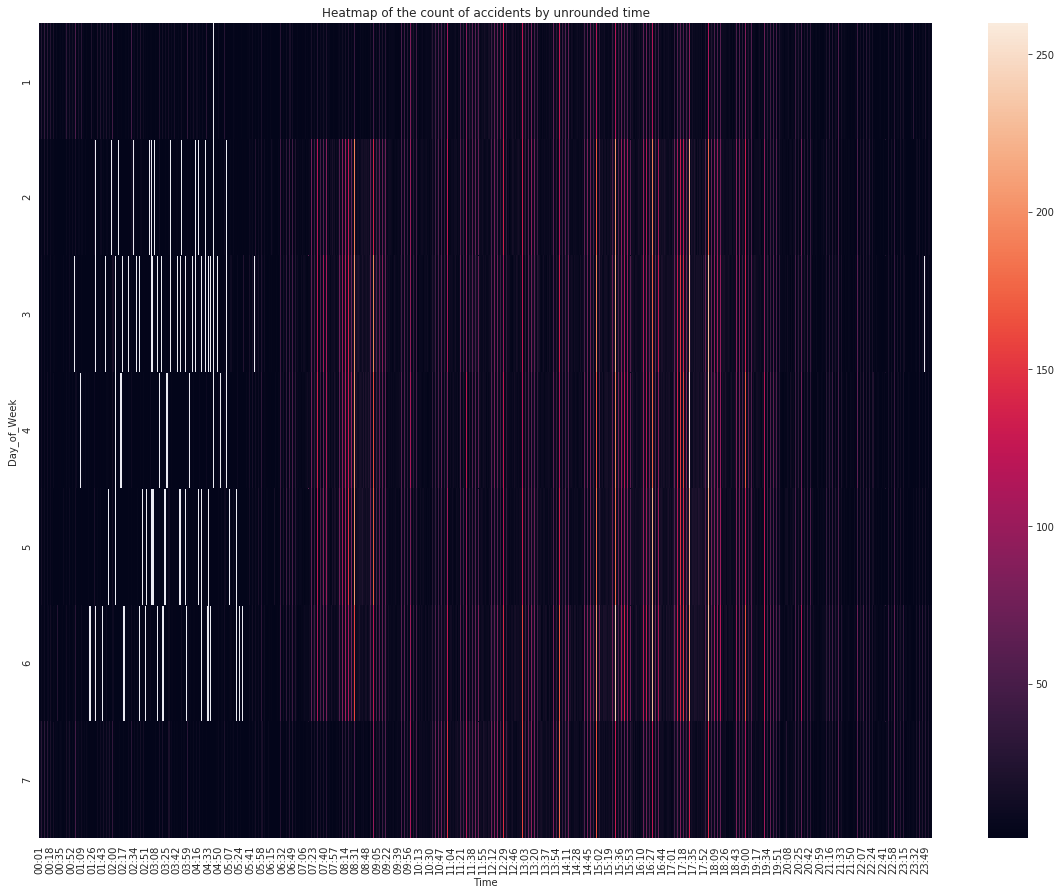

In [91]:
df_wtt=df_acc.groupby(['Day_of_Week','Time']).size().unstack()
plt.figure(2, figsize=(20,15))
sns.heatmap(data=df_wtt)
plt.title('Heatmap of the count of accidents by unrounded time')

Text(0.5, 1.0, 'Heatmap of the count of accidents by unrounded time when police did attend')

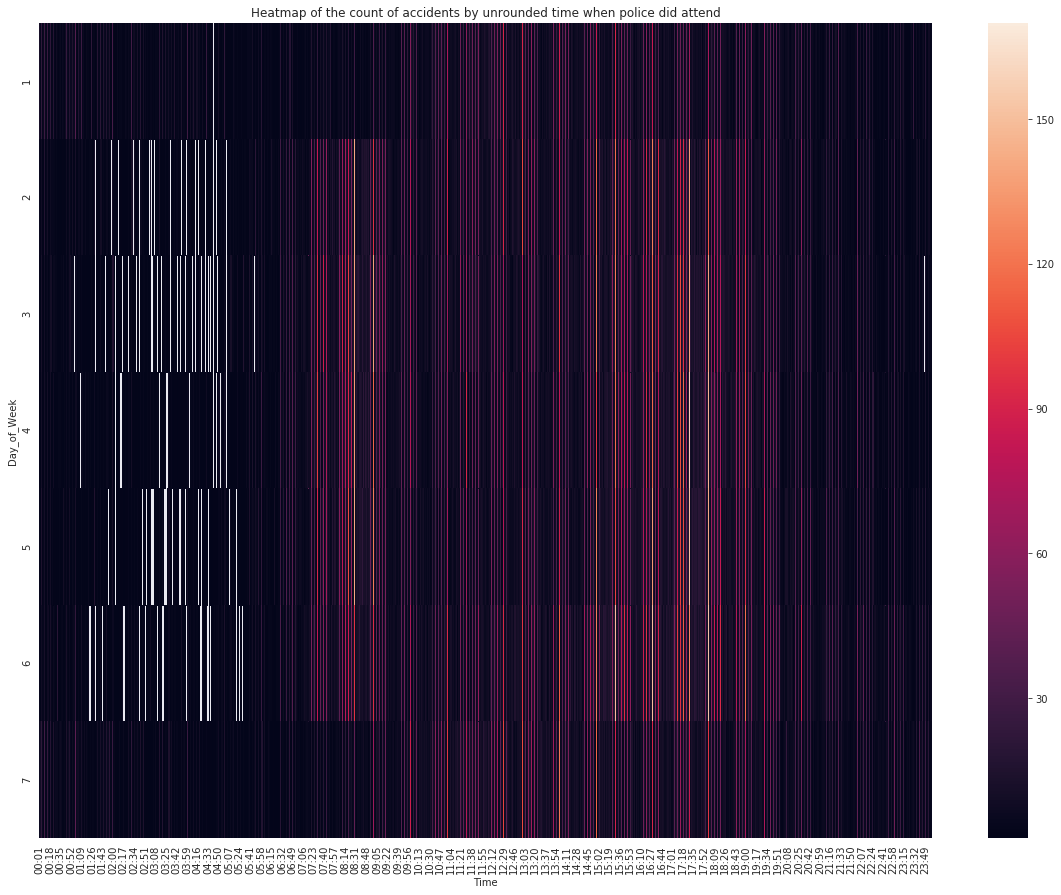

In [125]:
df_wtt_yes=df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1].groupby(['Day_of_Week','Time']).size().unstack()
plt.figure(2, figsize=(20,15))
sns.heatmap(data=df_wtt_yes)
plt.title('Heatmap of the count of accidents by unrounded time when police did attend')

Text(0.5, 1.0, 'Heatmap of the count of accidents by unrounded time when police did not attend')

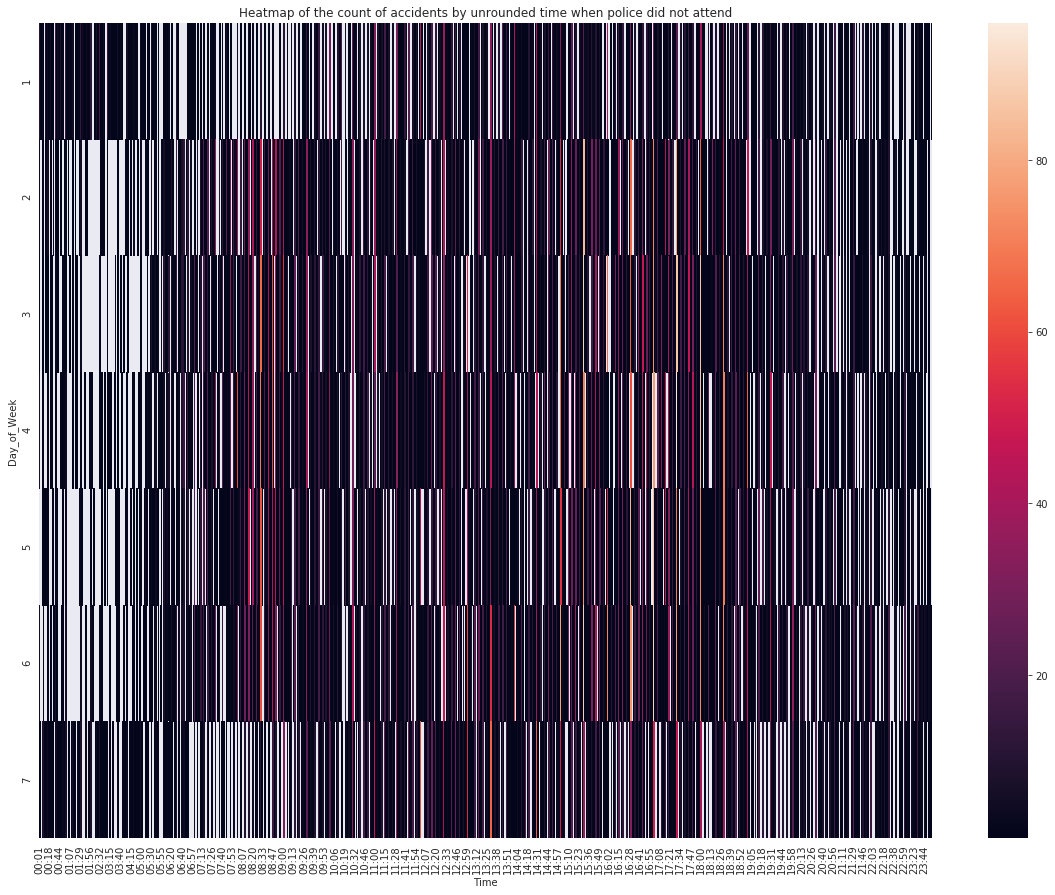

In [124]:
df_wtt_no=df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0].groupby(['Day_of_Week','Time']).size().unstack()
plt.figure(2, figsize=(20,15))
sns.heatmap(data=df_wtt_no)
plt.title('Heatmap of the count of accidents by unrounded time when police did not attend')

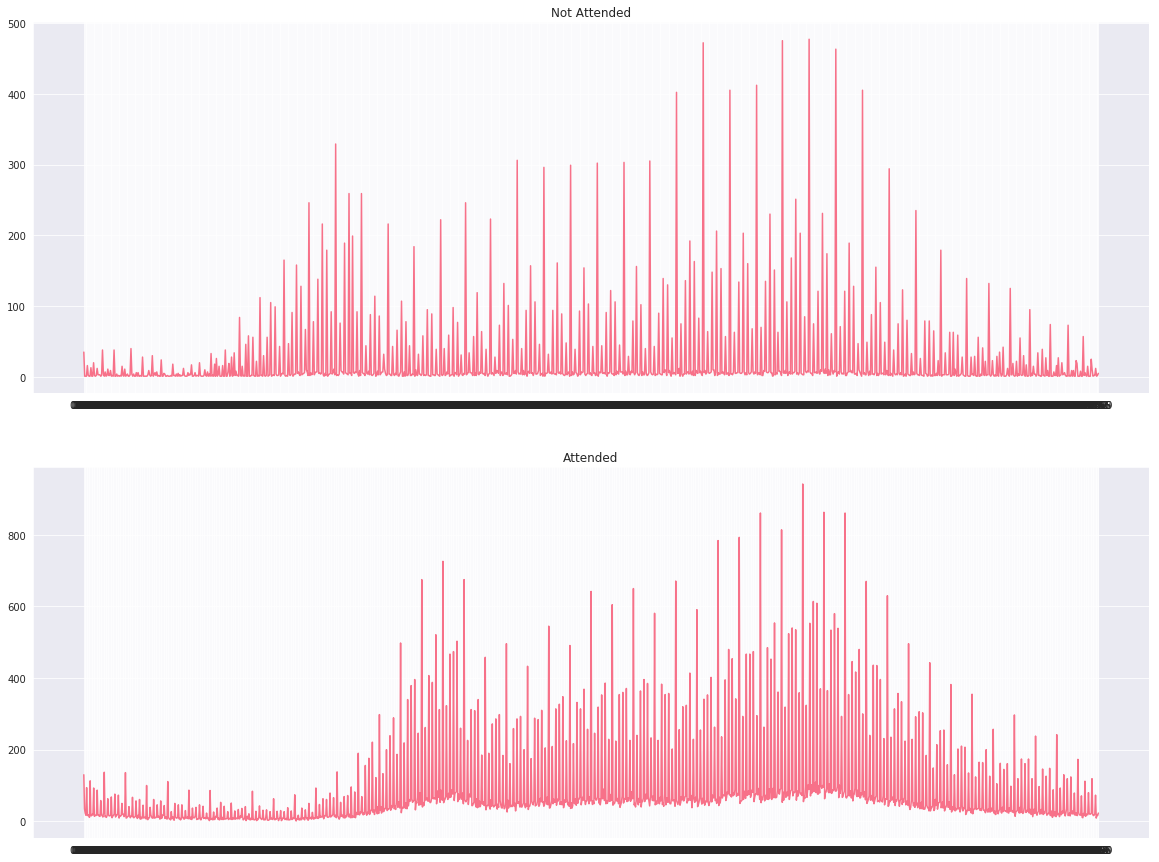

In [123]:
df_wtt_no_count=df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 0].groupby(['Time']).size()
df_wtt_yes_count=df_acc[df_acc.Did_Police_Officer_Attend_Scene_of_Accident == 1].groupby(['Time']).size()
df_wtt_count=pd.DataFrame({'Not Attended':df_wtt_no_count,'Attended':df_wtt_yes_count})

fig,(ax1,ax2)=plt.subplots(2,1,figsize=(20,15))
ax1.set_title('Not Attended')
sns.lineplot(data=df_wtt_count['Not Attended'],ax=ax1)

ax2.set_title('Attended')
sns.lineplot(data=df_wtt_count['Attended'],ax=ax2)

In [126]:
df_wtt_count

,Not Attended,Attended
00:01,35.0,130
00:02,1.0,35
00:03,1.0,23
00:04,1.0,17
00:05,16.0,94
00:06,2.0,16
00:07,1.0,17
00:08,NaN,18
00:09,1.0,11
00:10,13.0,113


In [84]:
df_acc.shape

(146322, 44)

## Machine Learning 

In [50]:
df_acc.columns
# df_acc.isna().sum()

Index(['Accident_Index', 'Location_Easting_OSGR', 'Location_Northing_OSGR', 'Longitude', 'Latitude', 'Police_Force', 'Accident_Severity', 'Number_of_Vehicles', 'Number_of_Casualties', 'Date', 'Day_of_Week', 'Time', 'Local_Authority_(District)', 'Local_Authority_(Highway)', '1st_Road_Class', '1st_Road_Number', 'Road_Type', 'Speed_limit', 'Junction_Detail', 'Junction_Control', '2nd_Road_Class', '2nd_Road_Number', 'Pedestrian_Crossing-Human_Control', 'Pedestrian_Crossing-Physical_Facilities', 'Light_Conditions', 'Weather_Conditions', 'Road_Surface_Conditions', 'Special_Conditions_at_Site', 'Carriageway_Hazards', 'Urban_or_Rural_Area', 'Did_Police_Officer_Attend_Scene_of_Accident', 'LSOA_of_Accident_Location', 'dt', 'Month', 'Hour', 'Time_int', 'Date_int', 'Holiday', 'Holiday-1', 'Holiday-2', 'Holiday+1', 'Holiday+2', 'Time_rounded', 'Rush Hour'], dtype='object')

In [51]:
columns = [
 'Date', 
 'dt',
 'Location_Easting_OSGR', 
 'Location_Northing_OSGR', 
 'Longitude',
 'Latitude', 
 'Number_of_Vehicles', 
 'Number_of_Casualties',
 'Time_int',
 'Date_int',
 'Time',
 'Speed_limit', 
 'Day_of_Week',
 'Month', 
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force', 
 'Accident_Severity', 
 'Local_Authority_(District)', 
 'Local_Authority_(Highway)', 
 '1st_Road_Class', 
 '1st_Road_Number', 
 'Road_Type', 
 'Junction_Detail', 
 'Junction_Control', 
 '2nd_Road_Class',
 '2nd_Road_Number', 
 'Pedestrian_Crossing-Human_Control', 
 'Pedestrian_Crossing-Physical_Facilities', 
 'Light_Conditions', 
 'Weather_Conditions', 
 'Road_Surface_Conditions', 
 'Special_Conditions_at_Site', 
 'Carriageway_Hazards', 
 'Urban_or_Rural_Area', 
 'LSOA_of_Accident_Location', 
 'Did_Police_Officer_Attend_Scene_of_Accident'
]
len(columns)

43

In [52]:
#column types
column_types = ['time']*2 + \
               ['real']*8 + \
               ['enum' for _ in range(len(columns) - 10)] 
len(column_types)
for o in (zip(columns,column_types)):
    print(o)


('Date', 'time')
('dt', 'time')
('Location_Easting_OSGR', 'real')
('Location_Northing_OSGR', 'real')
('Longitude', 'real')
('Latitude', 'real')
('Number_of_Vehicles', 'real')
('Number_of_Casualties', 'real')
('Time_int', 'real')
('Date_int', 'real')
('Time', 'enum')
('Speed_limit', 'enum')
('Day_of_Week', 'enum')
('Month', 'enum')
('Hour', 'enum')
('Rush Hour', 'enum')
('Holiday', 'enum')
('Holiday-1', 'enum')
('Holiday-2', 'enum')
('Holiday+1', 'enum')
('Holiday+2', 'enum')
('Time_rounded', 'enum')
('Police_Force', 'enum')
('Accident_Severity', 'enum')
('Local_Authority_(District)', 'enum')
('Local_Authority_(Highway)', 'enum')
('1st_Road_Class', 'enum')
('1st_Road_Number', 'enum')
('Road_Type', 'enum')
('Junction_Detail', 'enum')
('Junction_Control', 'enum')
('2nd_Road_Class', 'enum')
('2nd_Road_Number', 'enum')
('Pedestrian_Crossing-Human_Control', 'enum')
('Pedestrian_Crossing-Physical_Facilities', 'enum')
('Light_Conditions', 'enum')
('Weather_Conditions', 'enum')
('Road_Surface_C

In [53]:
df=df_acc.sample(frac=1).reset_index(drop=True)[columns].copy()
train_df = df[:int(len(df)*0.8)]
test_df  = df[int(len(df)*0.8):]


#check the imbalance in test set
print (test_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(1).sum(),
       test_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum())
print ('Police attended in the {}% of cases'.
        format(round((test_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum()/
                      len(test_df))
                                                     *100)))

23989 5276
Police attended in the 18.0% of cases


In [54]:
#check the imbalance in train set
print (train_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(1).sum(),
       train_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum())
print ('Police attended in the {}% of cases'.
        format(round((train_df.Did_Police_Officer_Attend_Scene_of_Accident.eq(0).sum()/
                      len(train_df))
                                                     *100)))

95618 21439
Police attended in the 18.0% of cases


In [55]:
# h2o.cluster().shutdown()
# h2o.remove_all()

In [56]:
## Import data into h2o
h2o.init(ip='localhost', port=54321) #nthreads=70, 
# h2o.connect(ip='192.168.0.31',  port=54321)


Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_152-release"; OpenJDK Runtime Environment (build 1.8.0_152-release-1056-b12); OpenJDK 64-Bit Server VM (build 25.152-b12, mixed mode)
  Starting server from /home/norayrm/.conda/envs/keras/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpt3cz7m7r
  JVM stdout: /tmp/tmpt3cz7m7r/h2o_norayrm_started_from_python.out
  JVM stderr: /tmp/tmpt3cz7m7r/h2o_norayrm_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O cluster uptime:,01 secs
H2O cluster timezone:,America/Chicago
H2O data parsing timezone:,UTC
H2O cluster version:,3.28.0.1
H2O cluster version age:,27 days
H2O cluster name:,H2O_from_python_norayrm_4dwbzv
H2O cluster total nodes:,1
H2O cluster free memory:,26.67 Gb
H2O cluster total cores:,72
H2O cluster allowed cores:,72
H2O cluster status:,"accepting new members, healthy"


In [57]:
## import data to h2o
train_d = h2o.H2OFrame(train_df, column_types=column_types, destination_frame='train')
train,val = train_d.split_frame(ratios=[0.8])
# val = h2o.H2OFrame(val_pd,  column_types=column_types)
test = h2o.H2OFrame(test_df, column_types=column_types, destination_frame='test')

Parse progress: |█████████████████████████████████████████████████████████| 100%
Parse progress: |█████████████████████████████████████████████████████████| 100%


In [58]:
train.shape

(93643, 43)

## XGBoost

In [59]:
## set predictors and response
predictors = train.columns[:-1]

remove = [
#         'Date', 
        'dt',
#         'Location_Easting_OSGR', 
#         'Location_Northing_OSGR', 
        'Longitude',
        'Latitude',
        'Local_Authority_(District)', 
#         'Local_Authority_(Highway)',
        'LSOA_of_Accident_Location',
        '1st_Road_Number',
        '2nd_Road_Number',
        'Time',
#         'Time_rounded',
        'Time_int',
#         'Police_Force',
#          'Weather_Conditions',
          ]
for it in remove:
    predictors.remove(it)

response = 'Did_Police_Officer_Attend_Scene_of_Accident'
predictors

['Date',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Date_int',
 'Speed_limit',
 'Day_of_Week',
 'Month',
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force',
 'Accident_Severity',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area']

xgboost Model Build progress: |███████████████████████████████████████████| 100%
Time to train (sec):  108.84812307357788
xgboost prediction progress: |████████████████████████████████████████████| 100%


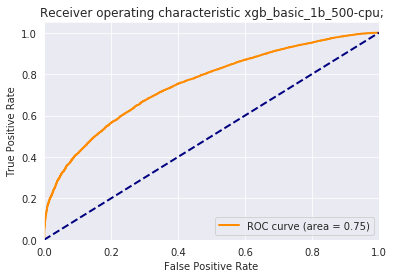

In [60]:

################################################################################################
## xgboost on cpu
model_xgb = H2OXGBoostEstimator(
#     balance_classes = True,
#     categorical_encoding='one_hot_explicit',
    model_id="xgb_basic_1b_500-cpu",
    ntrees=500
    ,max_depth=15
    ,tree_method='exact'
#     ,nfolds=7
    ,score_tree_interval=5
    ,min_rows = 50
    ,distribution='bernoulli'
    ,sample_rate=1
    ,col_sample_rate=1
    ,col_sample_rate_per_tree=1
    ,learn_rate=0.02
    ,stopping_rounds=10
    ,stopping_tolerance=0.0001
    ,stopping_metric="AUC" #"misclassification" #"logloss" #"misclassification" # "AUCPR"  #   "AUC" #
    ,score_each_iteration=False
    # ,keep_cross_validation_predictions=True
    ,seed=4413976168041433600
    ,backend='cpu'
)

t_start=time.time()
model_xgb.train(x=predictors, y=response, training_frame=train_d ) #training_frame=train, validation_frame=val)
# model_xgb.train(x=predictors, y=response, training_frame=train, validation_frame=val)

tt=time.time()-t_start
print("Time to train (sec): ", tt)

prediction_BOOL_xgb=draw_roc(test,model_xgb,False)

Using the k-fold validation does not seem to increase the performance significantly of the model in this case.

In [61]:
print( model_xgb.model_performance(test))


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.12894580443627002
RMSE: 0.3590902455320529
LogLoss: 0.4069250030481149
Mean Per-Class Error: 0.31335200828557674
AUC: 0.7536273496087779
AUCPR: 0.9292146598285767
Gini: 0.5072546992175557

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4366854495472378: 


,,0,1,Error,Rate
0,0,275.0,5001.0,0.9479,(5001.0/5276.0)
1,1,111.0,23878.0,0.0046,(111.0/23989.0)
2,Total,386.0,28879.0,0.1747,(5112.0/29265.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.436685,0.903306,346.0
1,max f2,0.234290,0.958045,380.0
2,max f0point5,0.689822,0.868604,240.0
3,max accuracy,0.487282,0.825594,333.0
4,max precision,0.993602,1.000000,0.0
5,max recall,0.088884,1.000000,398.0
6,max specificity,0.993602,1.000000,0.0
7,max absolute_mcc,0.786635,0.294913,173.0
8,max min_per_class_accuracy,0.799898,0.684230,163.0
9,max mean_per_class_accuracy,0.809021,0.686648,156.0



Gains/Lift Table: Avg response rate: 81.97 %, avg score: 81.68 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.990706,1.211607,1.211607,0.993174,0.991970,0.993174,0.991970,0.012131,0.012131,21.160694,21.160694
1,,2,0.020024,0.989142,1.219934,1.215771,1.000000,0.989899,0.996587,0.990935,0.012214,0.024344,21.993414,21.577054
2,,3,0.030002,0.987254,1.219934,1.217155,1.000000,0.988285,0.997722,0.990053,0.012172,0.036517,21.993414,21.715524
3,,4,0.040014,0.984618,1.215771,1.216809,0.996587,0.985967,0.997438,0.989031,0.012172,0.048689,21.577054,21.680877
4,,5,0.050026,0.981902,1.199116,1.213268,0.982935,0.983336,0.994536,0.987891,0.012006,0.060694,19.911615,21.326783
5,,6,0.100017,0.970055,1.203257,1.208264,0.986329,0.975816,0.990434,0.981856,0.060153,0.120847,20.325698,20.826411
6,,7,0.150009,0.958196,1.184078,1.200204,0.970608,0.964120,0.983827,0.975945,0.059194,0.180041,18.407825,20.020399
7,,8,0.200000,0.944855,1.155727,1.189087,0.947368,0.951757,0.974714,0.969899,0.057776,0.237817,15.572708,18.908666
8,,9,0.300017,0.912557,1.137410,1.171859,0.932354,0.929271,0.960592,0.956355,0.113760,0.351578,13.741041,17.185928
9,,10,0.400000,0.878944,1.085266,1.150215,0.889610,0.895800,0.942850,0.941219,0.108508,0.460086,8.526608,15.021468


xgboost prediction progress: |████████████████████████████████████████████| 100%


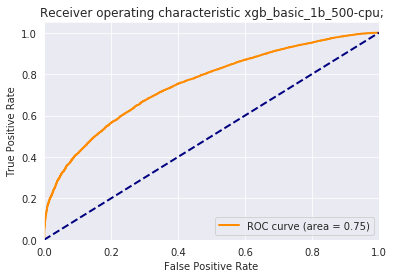

xgboost prediction progress: |████████████████████████████████████████████| 100%


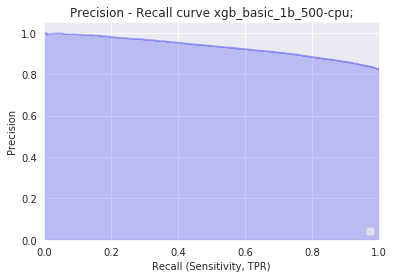

xgboost prediction progress: |████████████████████████████████████████████| 100%


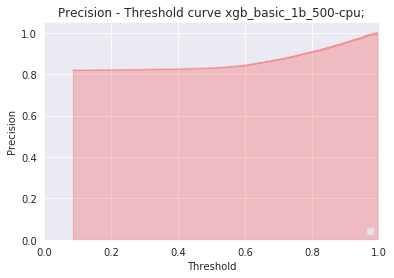

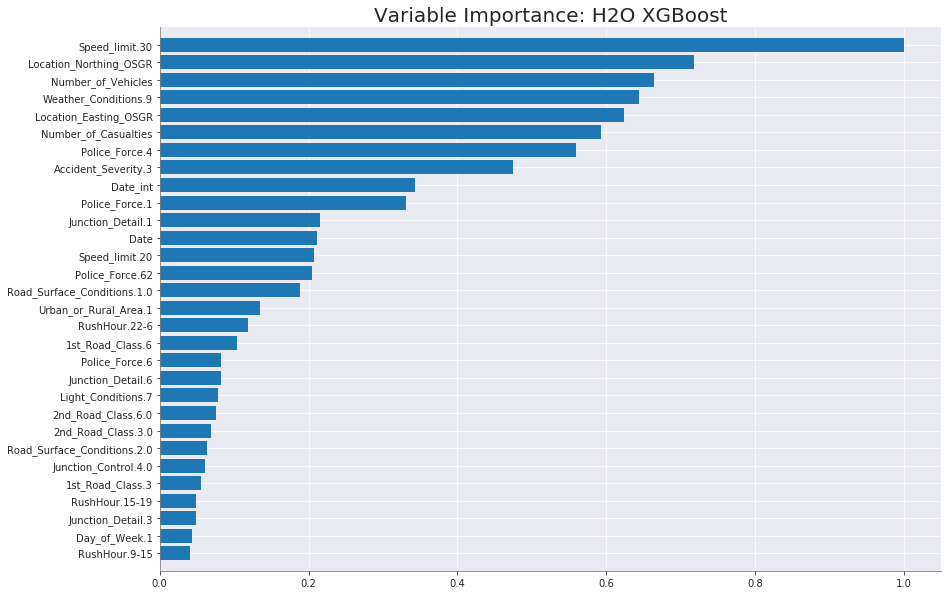

In [62]:
pred_xgb=draw_roc(test,model_xgb,False)
pr=draw_prec_recall(test,model_xgb,False)
pt=draw_prec_thr(test,model_xgb,False)


# Drav variable importances from h2o
model_xgb.varimp_plot(30)

In [63]:
# Print variable importance list
[[i[0],round(i[2],1)] for i in model_xgb.varimp()]

[['Speed_limit.30', 1.0],
 ['Location_Northing_OSGR', 0.7],
 ['Number_of_Vehicles', 0.7],
 ['Weather_Conditions.9', 0.6],
 ['Location_Easting_OSGR', 0.6],
 ['Number_of_Casualties', 0.6],
 ['Police_Force.4', 0.6],
 ['Accident_Severity.3', 0.5],
 ['Date_int', 0.3],
 ['Police_Force.1', 0.3],
 ['Junction_Detail.1', 0.2],
 ['Date', 0.2],
 ['Speed_limit.20', 0.2],
 ['Police_Force.62', 0.2],
 ['Road_Surface_Conditions.1.0', 0.2],
 ['Urban_or_Rural_Area.1', 0.1],
 ['RushHour.22-6', 0.1],
 ['1st_Road_Class.6', 0.1],
 ['Police_Force.6', 0.1],
 ['Junction_Detail.6', 0.1],
 ['Light_Conditions.7', 0.1],
 ['2nd_Road_Class.6.0', 0.1],
 ['2nd_Road_Class.3.0', 0.1],
 ['Road_Surface_Conditions.2.0', 0.1],
 ['Junction_Control.4.0', 0.1],
 ['1st_Road_Class.3', 0.1],
 ['RushHour.15-19', 0.0],
 ['Junction_Detail.3', 0.0],
 ['Day_of_Week.1', 0.0],
 ['RushHour.9-15', 0.0],
 ['Light_Conditions.1', 0.0],
 ['Road_Type.6', 0.0],
 ['Accident_Severity.1', 0.0],
 ['Pedestrian_Crossing-Physical_Facilities.0', 0.0],
 

In [64]:
################################################################################################
# real_v= pred_df.if_failed
real_v = test['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values
pred_xgb = model_xgb.predict(test)
p_yes_xgb = pred_xgb.as_data_frame()['p1']

# pred_gbm=draw_roc(test,model_gbm,False)

for t in range(100,800,5):
    print_stats(t/1000,real_v, p_yes_xgb)
    print(' \n ')

xgboost prediction progress: |████████████████████████████████████████████| 100%
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.75
F1 =  0.9
MCC =  0.0245
Threshold =  0.1
[[    6  5270]
 [    2 23987]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.778
F1 =  0.9
MCC =  0.0273
Threshold =  0.105
[[    7  5269]
 [    2 23987]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.002
NPV =  0.8
F1 =  0.9
MCC =  0.0298
Threshold =  0.11
[[    8  5268]
 [    2 23987]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.002
NPV =  0.833
F1 =  0.9
MCC =  0.0344
Threshold =  0.115
[[   10  5266]
 [    2 23987]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.002
NPV =  0.786
F1 =  0.9
MCC =  0.0345
Threshold =  0.12
[[   11  5265]
 [    3 23986]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.002
NPV =  0.8
F1 =

Precsision =  0.824
Sensitivity =  0.998
Specificity =  0.031
NPV =  0.78
F1 =  0.9
MCC =  0.1323
Threshold =  0.335
[[  163  5113]
 [   46 23943]]
 
 
Accuracy =  82.39999999999999
Precsision =  0.824
Sensitivity =  0.998
Specificity =  0.031
NPV =  0.769
F1 =  0.9
MCC =  0.1319
Threshold =  0.34
[[  166  5110]
 [   50 23939]]
 
 
Accuracy =  82.39999999999999
Precsision =  0.824
Sensitivity =  0.998
Specificity =  0.032
NPV =  0.766
F1 =  0.9
MCC =  0.1332
Threshold =  0.345
[[  170  5106]
 [   52 23937]]
 
 
Accuracy =  82.39999999999999
Precsision =  0.824
Sensitivity =  0.998
Specificity =  0.033
NPV =  0.768
F1 =  0.9
MCC =  0.1354
Threshold =  0.35
[[  175  5101]
 [   53 23936]]
 
 
Accuracy =  82.39999999999999
Precsision =  0.824
Sensitivity =  0.998
Specificity =  0.034
NPV =  0.772
F1 =  0.9
MCC =  0.1375
Threshold =  0.355
[[  179  5097]
 [   53 23936]]
 
 
Accuracy =  82.39999999999999
Precsision =  0.825
Sensitivity =  0.998
Specificity =  0.034
NPV =  0.768
F1 =  0.9
MCC

Precsision =  0.839
Sensitivity =  0.97
Specificity =  0.152
NPV =  0.523
F1 =  0.9
MCC =  0.2093
Threshold =  0.57
[[  800  4476]
 [  730 23259]]
 
 
Accuracy =  82.1
Precsision =  0.839
Sensitivity =  0.967
Specificity =  0.158
NPV =  0.514
F1 =  0.9
MCC =  0.2107
Threshold =  0.575
[[  835  4441]
 [  788 23201]]
 
 
Accuracy =  82.1
Precsision =  0.84
Sensitivity =  0.965
Specificity =  0.165
NPV =  0.508
F1 =  0.9
MCC =  0.2131
Threshold =  0.58
[[  873  4403]
 [  844 23145]]
 
 
Accuracy =  82.0
Precsision =  0.841
Sensitivity =  0.963
Specificity =  0.171
NPV =  0.503
F1 =  0.9
MCC =  0.2144
Threshold =  0.585
[[  903  4373]
 [  894 23095]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.842
Sensitivity =  0.96
Specificity =  0.179
NPV =  0.497
F1 =  0.9
MCC =  0.217
Threshold =  0.59
[[  943  4333]
 [  954 23035]]
 
 
Accuracy =  81.89999999999999
Precsision =  0.843
Sensitivity =  0.958
Specificity =  0.187
NPV =  0.492
F1 =  0.9
MCC =  0.2199
Threshold =  0.595
[[  986  4290

In [65]:
print_stats(0.78,real_v, p_yes_xgb)

Accuracy =  71.0
Precsision =  0.901
Sensitivity =  0.726
Specificity =  0.636
NPV =  0.338
F1 =  0.8
MCC =  0.294
Threshold =  0.795
[[ 3358  1918]
 [ 6581 17408]]


MCC is arround 0.3 due to response class imbalance

## GBM 

In [66]:
## set predictors and response
predictors = train.columns[:-1]

# list of features to be removed
remove = [
#         'Date', 
#         'dt',
#         'Location_Easting_OSGR', 
#         'Location_Northing_OSGR', 
        'Longitude',
        'Latitude',
        'Local_Authority_(District)', 
        'Local_Authority_(Highway)',
        'LSOA_of_Accident_Location',
        '1st_Road_Number',
        '2nd_Road_Number',
        'Time',
#         'Time_rounded',
#         'Time_int',
#         'Police_Force',
          ]
for it in remove:
    predictors.remove(it)

response = 'Did_Police_Officer_Attend_Scene_of_Accident'
predictors

['Date',
 'dt',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Time_int',
 'Date_int',
 'Speed_limit',
 'Day_of_Week',
 'Month',
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force',
 'Accident_Severity',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area']

In [67]:
#######################################################################################
## GBM
# # Create and train GBM
model_gbm = H2OGradientBoostingEstimator(
    model_id="gbm_basic"
    ,balance_classes = True
    ,ntrees= 200 # 74
    ,max_depth=7
#     ,nfolds=5
    # ,fold_assignment='Sparse'
    ,score_tree_interval=10
    ,min_rows = 100
    ,distribution='bernoulli'
    ,sample_rate=0.8
    ,col_sample_rate=0.8
    ,col_sample_rate_per_tree=0.8
    ,learn_rate=0.08
    # ,stopping_tolerance=0.01 #10-fold increase in threshold as defined in rf_v1
    # ,stopping_rounds=0
    , stopping_metric="AUC"  #"misclassification" # "AUCPR" # "logloss" # 
    ,score_each_iteration=False
    # ,keep_cross_validation_predictions=True
    ,seed=4413976168041433600
)
t_start=time.time()
model_gbm.train(x=predictors, y=response, training_frame=train_d )#, validation_frame=val)
# model_gbm.train(x=predictors, y=response, training_frame=train, validation_frame=val)

tt=time.time()-t_start
print("Time to train (sec): ", tt)

gbm Model Build progress: |███████████████████████████████████████████████| 100%
Time to train (sec):  15.404205322265625


In [68]:
print( model_gbm.model_performance(test))


ModelMetricsBinomial: gbm
** Reported on test data. **

MSE: 0.12983848684929614
RMSE: 0.3603310794939789
LogLoss: 0.41160612925347473
Mean Per-Class Error: 0.3180144900567423
AUC: 0.7502084999723938
AUCPR: 0.923847567674161
Gini: 0.5004169999447876

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4772516876196428: 


,,0,1,Error,Rate
0,0,334.0,4942.0,0.9367,(4942.0/5276.0)
1,1,175.0,23814.0,0.0073,(175.0/23989.0)
2,Total,509.0,28756.0,0.1749,(5117.0/29265.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.477252,0.902986,336.0
1,max f2,0.232909,0.958098,382.0
2,max f0point5,0.685644,0.868538,246.0
3,max accuracy,0.505118,0.825525,328.0
4,max precision,0.998855,1.000000,0.0
5,max recall,0.087067,1.000000,397.0
6,max specificity,0.998855,1.000000,0.0
7,max absolute_mcc,0.811290,0.292360,165.0
8,max min_per_class_accuracy,0.831771,0.679978,149.0
9,max mean_per_class_accuracy,0.832967,0.681986,148.0



Gains/Lift Table: Avg response rate: 81.97 %, avg score: 84.02 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.998117,1.219934,1.219934,1.000000,0.998621,1.000000,0.998621,0.012214,0.012214,21.993414,21.993414
1,,2,0.020024,0.997370,1.211607,1.215771,0.993174,0.997746,0.996587,0.998183,0.012131,0.024344,21.160694,21.577054
2,,3,0.030002,0.996395,1.219934,1.217155,1.000000,0.996919,0.997722,0.997763,0.012172,0.036517,21.993414,21.715524
3,,4,0.040014,0.995168,1.211607,1.215767,0.993174,0.995831,0.996584,0.997279,0.012131,0.048647,21.160694,21.576698
4,,5,0.050026,0.993776,1.207443,1.214101,0.989761,0.994483,0.995219,0.996720,0.012089,0.060736,20.744334,21.410112
5,,6,0.100017,0.985317,1.199922,1.207014,0.983595,0.989670,0.989409,0.993196,0.059986,0.120722,19.992155,20.701375
6,,7,0.150009,0.975830,1.174906,1.196314,0.963090,0.980589,0.980638,0.988994,0.058735,0.179457,17.490581,19.631354
7,,8,0.200000,0.965378,1.162398,1.187836,0.952837,0.970731,0.973689,0.984429,0.058110,0.237567,16.239794,18.783609
8,,9,0.300017,0.938890,1.126991,1.167552,0.923813,0.952597,0.957062,0.973817,0.112718,0.350286,12.699074,16.755200
9,,10,0.400000,0.909222,1.092354,1.148756,0.895420,0.924192,0.941654,0.961413,0.109217,0.459502,9.235387,14.875568


gbm prediction progress: |████████████████████████████████████████████████| 100%


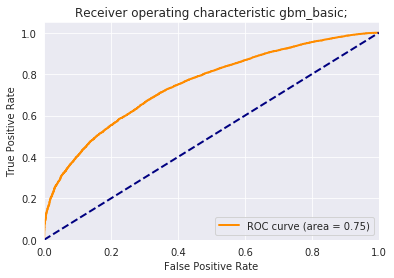

gbm prediction progress: |████████████████████████████████████████████████| 100%


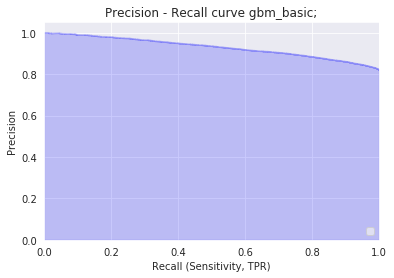

gbm prediction progress: |████████████████████████████████████████████████| 100%


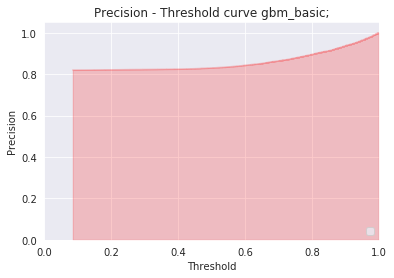

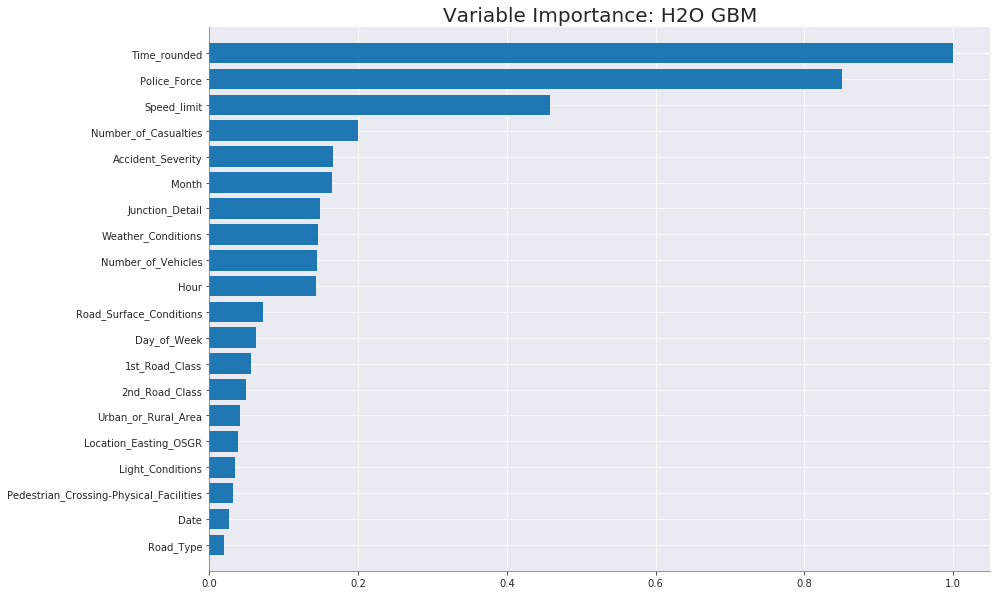

In [69]:
pred_gbm=draw_roc(test,model_gbm,False)

pr=draw_prec_recall(test,model_gbm,False)
pt=draw_prec_thr(test,model_gbm,False)


# Drav variable importances from h2o
model_gbm.varimp_plot(20)

In [70]:
# Print variable importance list
[[i[0],round(i[2],2)] for i in model_gbm.varimp()]

[['Time_rounded', 1.0],
 ['Police_Force', 0.85],
 ['Speed_limit', 0.46],
 ['Number_of_Casualties', 0.2],
 ['Accident_Severity', 0.17],
 ['Month', 0.17],
 ['Junction_Detail', 0.15],
 ['Weather_Conditions', 0.15],
 ['Number_of_Vehicles', 0.14],
 ['Hour', 0.14],
 ['Road_Surface_Conditions', 0.07],
 ['Day_of_Week', 0.06],
 ['1st_Road_Class', 0.06],
 ['2nd_Road_Class', 0.05],
 ['Urban_or_Rural_Area', 0.04],
 ['Location_Easting_OSGR', 0.04],
 ['Light_Conditions', 0.03],
 ['Pedestrian_Crossing-Physical_Facilities', 0.03],
 ['Date', 0.03],
 ['Road_Type', 0.02],
 ['Location_Northing_OSGR', 0.02],
 ['Time_int', 0.02],
 ['Junction_Control', 0.01],
 ['dt', 0.01],
 ['Date_int', 0.01],
 ['Special_Conditions_at_Site', 0.01],
 ['Carriageway_Hazards', 0.0],
 ['Holiday+2', 0.0],
 ['Rush Hour', 0.0],
 ['Holiday-1', 0.0],
 ['Holiday-2', 0.0],
 ['Holiday+1', 0.0],
 ['Pedestrian_Crossing-Human_Control', 0.0],
 ['Holiday', 0.0]]

In [71]:
################################################################################################
# real_v= pred_df.if_failed
real_v = test['Did_Police_Officer_Attend_Scene_of_Accident'].as_data_frame().values
pred_gbm = model_gbm.predict(test)
p_yes_gbm = pred_gbm.as_data_frame()['p1']

# pred_gbm=draw_roc(test,model_gbm,False)

for t in range(100,800,5):
    print_stats(t/1000,real_v, p_yes_gbm)
    print(' \n ')

gbm prediction progress: |████████████████████████████████████████████████| 100%
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.833
F1 =  0.9
MCC =  0.0243
Threshold =  0.1
[[    5  5271]
 [    1 23988]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.857
F1 =  0.9
MCC =  0.0272
Threshold =  0.105
[[    6  5270]
 [    1 23988]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.001
NPV =  0.75
F1 =  0.9
MCC =  0.0245
Threshold =  0.11
[[    6  5270]
 [    2 23987]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.002
NPV =  0.8
F1 =  0.9
MCC =  0.0298
Threshold =  0.115
[[    8  5268]
 [    2 23987]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.002
NPV =  0.8
F1 =  0.9
MCC =  0.0298
Threshold =  0.12
[[    8  5268]
 [    2 23987]]
 
 
Accuracy =  82.0
Precsision =  0.82
Sensitivity =  1.0
Specificity =  0.002
NPV =  0.818
F1 =

Sensitivity =  0.999
Specificity =  0.024
NPV =  0.781
F1 =  0.9
MCC =  0.1159
Threshold =  0.335
[[  125  5151]
 [   35 23954]]
 
 
Accuracy =  82.3
Precsision =  0.823
Sensitivity =  0.999
Specificity =  0.025
NPV =  0.789
F1 =  0.9
MCC =  0.1196
Threshold =  0.34
[[  131  5145]
 [   35 23954]]
 
 
Accuracy =  82.3
Precsision =  0.823
Sensitivity =  0.998
Specificity =  0.026
NPV =  0.791
F1 =  0.9
MCC =  0.1221
Threshold =  0.345
[[  136  5140]
 [   36 23953]]
 
 
Accuracy =  82.3
Precsision =  0.823
Sensitivity =  0.998
Specificity =  0.026
NPV =  0.793
F1 =  0.9
MCC =  0.1233
Threshold =  0.35
[[  138  5138]
 [   36 23953]]
 
 
Accuracy =  82.3
Precsision =  0.824
Sensitivity =  0.998
Specificity =  0.027
NPV =  0.794
F1 =  0.9
MCC =  0.1257
Threshold =  0.355
[[  143  5133]
 [   37 23952]]
 
 
Accuracy =  82.3
Precsision =  0.824
Sensitivity =  0.998
Specificity =  0.028
NPV =  0.798
F1 =  0.9
MCC =  0.1274
Threshold =  0.36
[[  146  5130]
 [   37 23952]]
 
 
Accuracy =  82.39999

Accuracy =  82.19999999999999
Precsision =  0.838
Sensitivity =  0.972
Specificity =  0.143
NPV =  0.526
F1 =  0.9
MCC =  0.2047
Threshold =  0.57
[[  757  4519]
 [  681 23308]]
 
 
Accuracy =  82.19999999999999
Precsision =  0.838
Sensitivity =  0.97
Specificity =  0.15
NPV =  0.522
F1 =  0.9
MCC =  0.2076
Threshold =  0.575
[[  790  4486]
 [  723 23266]]
 
 
Accuracy =  82.1
Precsision =  0.839
Sensitivity =  0.968
Specificity =  0.157
NPV =  0.516
F1 =  0.9
MCC =  0.2106
Threshold =  0.58
[[  829  4447]
 [  777 23212]]
 
 
Accuracy =  82.1
Precsision =  0.84
Sensitivity =  0.965
Specificity =  0.165
NPV =  0.511
F1 =  0.9
MCC =  0.2141
Threshold =  0.585
[[  872  4404]
 [  834 23155]]
 
 
Accuracy =  82.0
Precsision =  0.841
Sensitivity =  0.963
Specificity =  0.171
NPV =  0.502
F1 =  0.9
MCC =  0.2138
Threshold =  0.59
[[  900  4376]
 [  893 23096]]
 
 
Accuracy =  82.0
Precsision =  0.842
Sensitivity =  0.961
Specificity =  0.18
NPV =  0.505
F1 =  0.9
MCC =  0.2209
Threshold =  0.

In [72]:
print_stats(0.816032,real_v, p_yes_gbm)

Accuracy =  70.19999999999999
Precsision =  0.902
Sensitivity =  0.713
Specificity =  0.648
NPV =  0.332
F1 =  0.8
MCC =  0.2912
Threshold =  0.795
[[ 3420  1856]
 [ 6874 17115]]


Confusion matrix, without normalization
[[  322  4954]
 [  161 23828]]


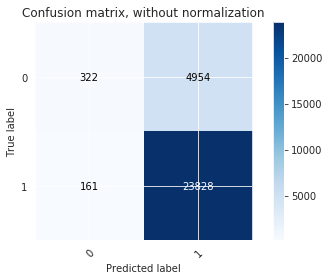

In [73]:
plot_confusion_matrix(0.4688,real_v,  pred_gbm.as_data_frame()['p1'], [0,1])
# pred_gbm

## GLM

In [75]:
## set predictors and response
predictors = train.columns[:-1]

remove = [
#         'Date', 
#         'dt',
#         'Location_Easting_OSGR', 
#         'Location_Northing_OSGR', 
        'Longitude',
        'Latitude',
#         'Local_Authority_(District)', 
#         'Local_Authority_(Highway)',
        'LSOA_of_Accident_Location',
        '1st_Road_Number',
        '2nd_Road_Number',
#         'Time',
#         'Time_rounded',
#         'Time_int',
#         'Police_Force',
#          'Weather_Conditions',
          ]
for it in remove:
    predictors.remove(it)

response = 'Did_Police_Officer_Attend_Scene_of_Accident'
predictors

['Date',
 'dt',
 'Location_Easting_OSGR',
 'Location_Northing_OSGR',
 'Number_of_Vehicles',
 'Number_of_Casualties',
 'Time_int',
 'Date_int',
 'Time',
 'Speed_limit',
 'Day_of_Week',
 'Month',
 'Hour',
 'Rush Hour',
 'Holiday',
 'Holiday-1',
 'Holiday-2',
 'Holiday+1',
 'Holiday+2',
 'Time_rounded',
 'Police_Force',
 'Accident_Severity',
 'Local_Authority_(District)',
 'Local_Authority_(Highway)',
 '1st_Road_Class',
 'Road_Type',
 'Junction_Detail',
 'Junction_Control',
 '2nd_Road_Class',
 'Pedestrian_Crossing-Human_Control',
 'Pedestrian_Crossing-Physical_Facilities',
 'Light_Conditions',
 'Weather_Conditions',
 'Road_Surface_Conditions',
 'Special_Conditions_at_Site',
 'Carriageway_Hazards',
 'Urban_or_Rural_Area']

glm Model Build progress: |███████████████████████████████████████████████| 100%
Time to train (sec):  5.121147871017456
glm prediction progress: |████████████████████████████████████████████████| 100%


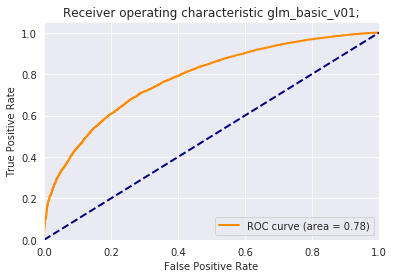

In [76]:

## Starting GLM

model_glm = H2OGeneralizedLinearEstimator(
    # balance_classes = True,
    # categorical_encoding='one_hot_explicit',
    max_iterations= 1000,
    early_stopping = False,
    objective_epsilon= 0.000001,
    alpha=0.3,
    lambda_ = 1e-4,
    model_id="glm_basic_v01",
    family='binomial'
)
t_start=time.time()
model_glm.train(x=predictors, y=response, training_frame=train_d) #, validation_frame=val)
tt=time.time()-t_start
print("Time to train (sec): ", tt)

prediction_glm=draw_roc(test,model_glm,False)


In [77]:
print( model_glm.model_performance(test))


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.12347814407218737
RMSE: 0.3513945703510334
LogLoss: 0.3918645963504399
Null degrees of freedom: 29264
Residual degrees of freedom: 28527
Null deviance: 27617.430062501346
Residual deviance: 22935.834824391248
AIC: 24411.834824391248
AUC: 0.7820290532453101
AUCPR: 0.9341298698154835
Gini: 0.5640581064906203

Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.49684354943399317: 


,,0,1,Error,Rate
0,0,688.0,4588.0,0.8696,(4588.0/5276.0)
1,1,401.0,23588.0,0.0167,(401.0/23989.0)
2,Total,1089.0,28176.0,0.1705,(4989.0/29265.0)



Maximum Metrics: Maximum metrics at their respective thresholds


,metric,threshold,value,idx
0,max f1,0.496844,0.904361,319.0
1,max f2,0.241974,0.958082,376.0
2,max f0point5,0.697591,0.879902,227.0
3,max accuracy,0.556307,0.830207,296.0
4,max precision,0.999254,1.000000,0.0
5,max recall,0.114488,1.000000,393.0
6,max specificity,0.999254,1.000000,0.0
7,max absolute_mcc,0.747906,0.338654,197.0
8,max min_per_class_accuracy,0.801864,0.709158,161.0
9,max mean_per_class_accuracy,0.815213,0.709944,151.0



Gains/Lift Table: Avg response rate: 81.97 %, avg score: 81.60 %


,,group,cumulative_data_fraction,lower_threshold,lift,cumulative_lift,response_rate,score,cumulative_response_rate,cumulative_score,capture_rate,cumulative_capture_rate,gain,cumulative_gain
0,,1,0.010012,0.997470,1.219934,1.219934,1.000000,0.998668,1.000000,0.998668,0.012214,0.012214,21.993414,21.993414
1,,2,0.020024,0.994370,1.219934,1.219934,1.000000,0.995921,1.000000,0.997295,0.012214,0.024428,21.993414,21.993414
2,,3,0.030002,0.991148,1.219934,1.219934,1.000000,0.992835,1.000000,0.995812,0.012172,0.036600,21.993414,21.993414
3,,4,0.040014,0.987518,1.215771,1.218892,0.996587,0.989444,0.999146,0.994218,0.012172,0.048772,21.577054,21.889235
4,,5,0.050026,0.983553,1.203280,1.215768,0.986348,0.985536,0.996585,0.992481,0.012047,0.060820,20.327975,21.576769
5,,6,0.100017,0.966876,1.194085,1.204930,0.978811,0.974999,0.987701,0.983743,0.059694,0.120514,19.408454,20.492982
6,,7,0.150009,0.952633,1.198254,1.202705,0.982228,0.959568,0.985877,0.975687,0.059902,0.180416,19.825383,20.270500
7,,8,0.200000,0.939262,1.162398,1.192630,0.952837,0.946116,0.977618,0.968295,0.058110,0.238526,16.239794,19.262996
8,,9,0.300017,0.912839,1.141578,1.175611,0.935770,0.925981,0.963667,0.954189,0.114177,0.352703,14.157827,17.561079
9,,10,0.400000,0.885378,1.110282,1.159281,0.910116,0.899654,0.950282,0.940558,0.111009,0.463713,11.028182,15.928134


glm prediction progress: |████████████████████████████████████████████████| 100%


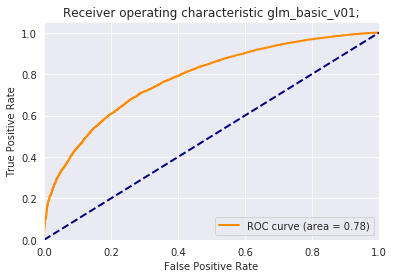

glm prediction progress: |████████████████████████████████████████████████| 100%


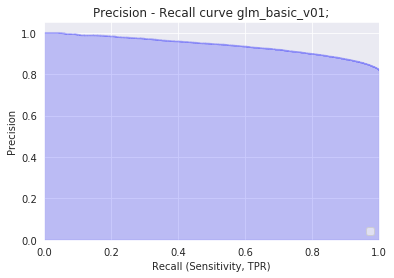

glm prediction progress: |████████████████████████████████████████████████| 100%


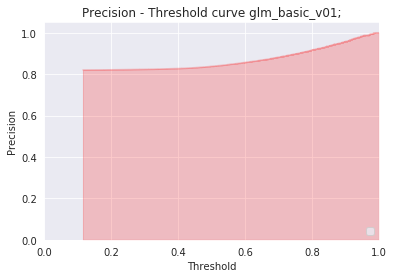

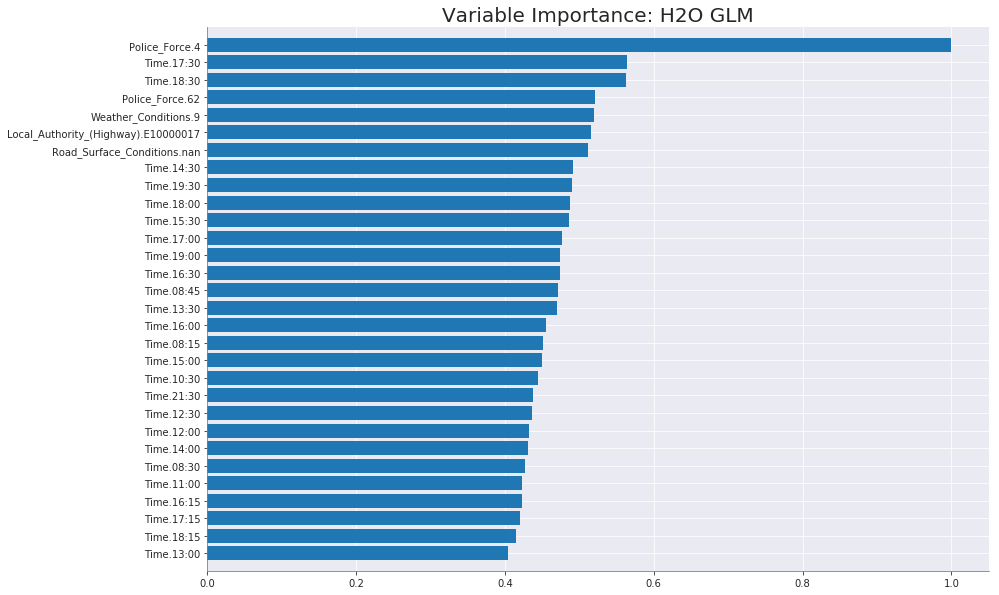

In [78]:
pred_glm=draw_roc(test,model_glm,False)

pr=draw_prec_recall(test,model_glm,False)
pt=draw_prec_thr(test,model_glm,False)


# Drav variable importances from h2o
model_glm.varimp_plot(30)

As illustrated on the above GLM model, the Time variable treated as a categorical has a peculiar effect on the model, even in the presence of rounded time and the hold out set being selected randomly. 
The performance of all the models do go up when includig the original Time variable, however we are apprehensive to include it since the reason could be a data leak. 

In [79]:
test[['Time','Time_rounded','Time_int']]

Time,Time_rounded,Time_int
17:05,17:00,1.57894e+09
16:40,16:45,1.57893e+09
14:15,14:15,1.57892e+09
10:00,10:00,1.57891e+09
18:05,18:00,1.57894e+09
14:40,14:45,1.57893e+09
12:20,12:15,1.57892e+09
19:24,19:30,1.57894e+09
18:15,18:15,1.57894e+09
13:30,13:30,1.57892e+09


In [80]:
len(test[['Time']].unique())

1393

In [81]:
test[['Time']].unique()

C1
00:01
00:02
00:03
00:04
00:05
00:06
00:07
00:08
00:09
00:10


### Auto Machine Learning

In [82]:
########################################################################################
# Run AutoML for 30 mins
aml = H2OAutoML(max_runtime_secs = 36000)
# aml.train(x=predictors, y=response, training_frame= train, #validation_frame=val,
#           leaderboard_frame = test)

# View the AutoML Leaderboard
lb = aml.leaderboard
lb
#



Parse progress: |█████████████████████████████████████████████████████████| 100%
This H2OFrame is empty.


The automl run for a considerable time does not seem to be able to produce models outperforming the xgboost above. 

In [83]:
pred_aml=draw_roc(test,aml.leader,False)
pred_aml=draw_prec_recall(test,aml.leader,False)
pred_aml=draw_prec_thr(test,aml.leader,False)


# Drav variable importances from h2o
aml.leader.varimp_plot(20)

AttributeError: 'NoneType' object has no attribute 'predict'